In [1]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 79.9 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

## Local Inference on GPU 
Model page: https://huggingface.co/google/medgemma-4b-it

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/google/medgemma-4b-it)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

The model you are trying to use is gated. Please make sure you have access to it by visiting the model page.To run inference, either set HF_TOKEN in your environment variables/ Secrets or run the following cell to login. 🤗

In [1]:
from huggingface_hub import login
login(new_session=False)

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from transformers import AutoProcessor, AutoModelForImageTextToText
import os
import torch
import requests
from PIL import Image
from transformers import pipeline
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd
import requests
from PIL import Image
import json, re
from PIL import ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import re
import math
import shutil
import zipfile
import tarfile
import tempfile
from typing import Tuple, Optional, List

import numpy as np
import pandas as pd
from PIL import Image
import pydicom
import nibabel as nib

In [6]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-text-to-text", model="google/medgemma-4b-it")
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/p-blog/candy.JPG"},
            {"type": "text", "text": "What animal is on the candy?"}
        ]
    },
]
pipe(text=messages)

In [5]:
!pip freeze > requirements.txt


# RG testing

In [5]:
df = pd.read_excel('/kaggle/input/mosmeddata-xr-chestpat-type-i-v-10-rg-v2/CT_XR_CHESTPAT_II/XR_CHESTPAT_II_2.0/XR_CHESTPAT_II_2anon.xlsx', sheet_name='Sheet1')
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


study_instance_anon  Unnamed: 1  Unnamed: 2  \
0  1.2.643.5.1.13.13.12.2.77.8252.100512041113051...         NaN         NaN   
1  1.2.643.5.1.13.13.12.2.77.8252.051012020815050...         NaN         NaN   
2  1.2.643.5.1.13.13.12.2.77.8252.040615020214131...         NaN         NaN   
3  1.2.643.5.1.13.13.12.2.77.8252.101208091304100...         NaN         NaN   
4  1.2.643.5.1.13.13.12.2.77.8252.091505070003070...         NaN         NaN   

   Unnamed: 3  Unnamed: 4  Unnamed: 5  Unnamed: 6  pathology  
0         NaN         NaN         NaN         NaN          0  
1         NaN         NaN         NaN         NaN          1  
2         NaN         NaN         NaN         NaN          1  
3         NaN         NaN         NaN         NaN          1  
4         NaN         NaN         NaN         NaN          1

In [46]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

def _heuristic_invert(arr_u8: np.ndarray) -> np.ndarray:
    """Инверсия, если края заметно светлее центра (типично для РГ)."""
    arr = arr_u8.astype(np.float32)
    H, W = arr.shape
    border = int(0.08 * min(H, W))
    if border > 0:
        center = arr[border:H-border, border:W-border]
        edges = np.concatenate([
            arr[:border, :].ravel(),
            arr[-border:, :].ravel(),
            arr[:, :border].ravel(),
            arr[:, -border:].ravel()
        ])
        if edges.mean() - center.mean() > 10:
            arr = 255.0 - arr
    return np.clip(arr, 0, 255).astype(np.uint8)

def _resize_keep_aspect(arr_u8: np.ndarray, longest: int | None) -> np.ndarray:
    """Опциональный ресайз по длинной стороне БЕЗ кропа и без рамок. Сохраняет пропорции."""
    if not longest:
        return arr_u8
    h, w = arr_u8.shape
    s = longest / max(h, w)
    if abs(s - 1.0) < 1e-6:
        return arr_u8
    nh, nw = max(1, int(round(h * s))), max(1, int(round(w * s)))
    return cv2.resize(arr_u8, (nw, nh), interpolation=cv2.INTER_LINEAR)

def _u8_to_pseudo_hu(arr_u8: np.ndarray, hu_range=(-1000.0, 3000.0)) -> np.ndarray:
    """Проецируем 0..255 -> HU (линейно) для симуляции окон КТ на PNG/JPG."""
    lo, hi = float(hu_range[0]), float(hu_range[1])
    arr = arr_u8.astype(np.float32) / 255.0
    return arr * (hi - lo) + lo

def _apply_hu_window_to_u8(arr_u8: np.ndarray, center: float, width: float,
                           hu_range=(-1000.0, 3000.0)) -> np.ndarray:
    """PNG/JPG -> pseudo-HU -> окно (C,W) -> [0..1] -> обратно в uint8 0..255."""
    hu = _u8_to_pseudo_hu(arr_u8, hu_range=hu_range)
    lo = center - width / 2.0
    hi = center + width / 2.0
    img = np.clip(hu, lo, hi)
    img = (img - lo) / max(hi - lo, 1e-6)  # 0..1
    img = (img * 255.0).clip(0, 255).astype(np.uint8)
    return img

def preprocess_xray_pil_v4(
    image_pil: Image.Image,
    *,
    preset: str = "default",              # 'default' | 'clahe' | 'clip'
    clip_window: tuple = (300, 1000),     # как Bone-окно для КТ
    hu_range: tuple = (-1000.0, 3000.0),  # проекция 0..255 -> pseudo-HU
    resize_longest: int | None = None,    # например, 1024; None — не менять размер
    do_clahe: bool = True,                # влияет только на 'clahe'
    make_3ch: bool = True,
    zscore: bool = False,                 # иначе [0,1]
    visualize: bool = True
):
    """
    Предобработка PNG/JPG рентгенов под инференс (например, MedGemma), без потери краёв.

    Три ветки:
      - 'default': эвристическая инверсия -> (опц. ресайз) -> нормализация
      - 'clahe'  : эвристическая инверсия -> CLAHE -> (опц. ресайз) -> нормализация
      - 'clip'   : эвристическая инверсия -> Pseudo-CT окно (C,W) -> (опц. ресайз) -> нормализация
                   (без CLAHE; окно имитирует Bone-представление на КТ)

    Возврат:
      visualize=False -> arr
      visualize=True  -> (arr, fig)  где fig показывает Original, CLAHE, CLIP
    """
    assert preset in {"default", "clahe", "clip"}, "preset: 'default' | 'clahe' | 'clip'"

    # --- базовые массивы ---
    imgL = image_pil.convert("L")
    orig_u8 = np.array(imgL, dtype=np.uint8)       # панель Original (как есть)
    inv_u8  = _heuristic_invert(orig_u8)           # для обработок

    # --- ветки обработки ---
    # 1) DEFAULT
    default_u8 = inv_u8.copy()

    # 2) CLAHE (только если включено)
    if do_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_u8 = clahe.apply(inv_u8)
    else:
        clahe_u8 = inv_u8

    # 3) CLIP (pseudo-CT window), без CLAHE
    c, w = clip_window
    clip_u8 = _apply_hu_window_to_u8(inv_u8, float(c), float(w), hu_range=hu_range)

    # --- опциональный ресайз каждой версии (сохранение пропорций, без кропа/рамок) ---
    orig_show = _resize_keep_aspect(orig_u8, resize_longest)
    clahe_show = _resize_keep_aspect(clahe_u8, resize_longest)
    clip_show  = _resize_keep_aspect(clip_u8,  resize_longest)

    # --- выбор того, что идёт на вход модели ---
    if preset == "default":
        chosen_u8 = _resize_keep_aspect(default_u8, resize_longest)
    elif preset == "clahe":
        chosen_u8 = clahe_show
    else:  # 'clip'
        chosen_u8 = clip_show

    # --- нормализация + 3 канала ---
    arr_f32 = chosen_u8.astype(np.float32)
    if zscore:
        m, s = float(arr_f32.mean()), float(arr_f32.std()) + 1e-6
        arr_norm = (arr_f32 - m) / s
    else:
        arr_norm = arr_f32 / 255.0

    arr_out = np.repeat(arr_norm[..., None], 3, axis=-1).astype(np.float32) if make_3ch else arr_norm.astype(np.float32)

    if not visualize:
        return arr_out

    # --- визуализация: три панели (Original, CLAHE, CLIP) ---
    fig = plt.figure(figsize=(12, 4))
    gs = fig.add_gridspec(1, 3)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(orig_show, cmap="gray")
    ax1.set_title("Original")
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(clahe_show, cmap="gray")
    ax2.set_title("CLAHE (после инверсии)")
    ax2.axis("off")

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(clip_show, cmap="gray")
    ax3.set_title(f"CLIP (C={c}, W={w}) — pseudo-CT (без CLAHE)")
    ax3.axis("off")

    fig.tight_layout()
    return arr_out, fig


In [7]:
# Load model directly
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("google/medgemma-4b-it")
model = AutoModelForImageTextToText.from_pretrained("google/medgemma-4b-it")
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/p-blog/candy.JPG"},
            {"type": "text", "text": "What animal is on the candy?"}
        ]
    },
]
inputs = processor.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=40)

print(processor.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The animal on the candy is a **bird**.
<end_of_turn>


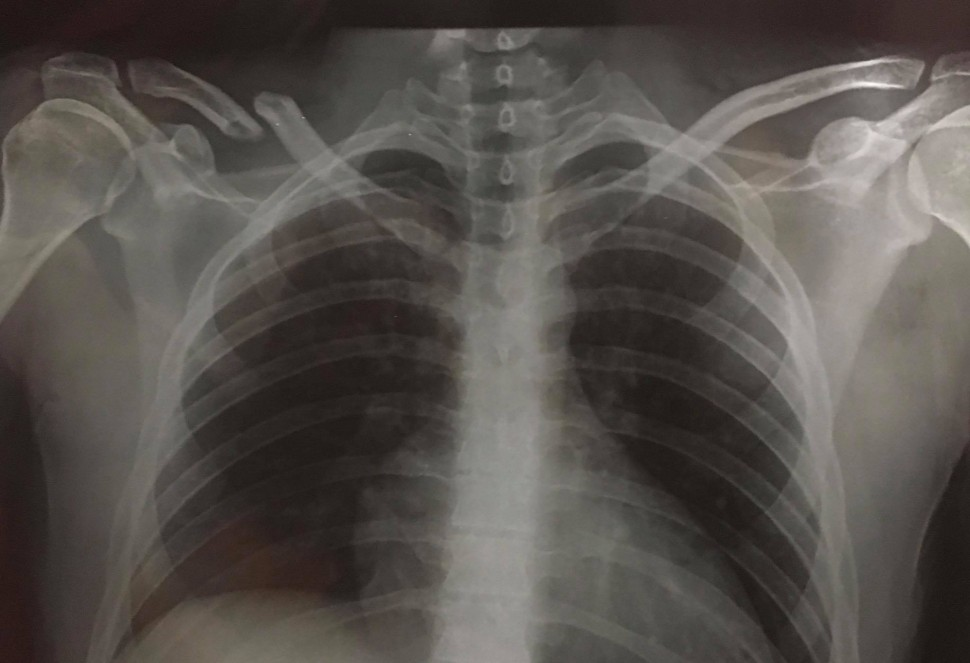

In [8]:
import os
import torch
import requests
from PIL import Image
from transformers import pipeline
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd

image_url = "https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png"
image_url = 'https://motogonki.ru/images/news/add201703241733262.jpg'
image = Image.open(requests.get(image_url, headers={"User-Agent": "example"}, stream=True).raw)
image

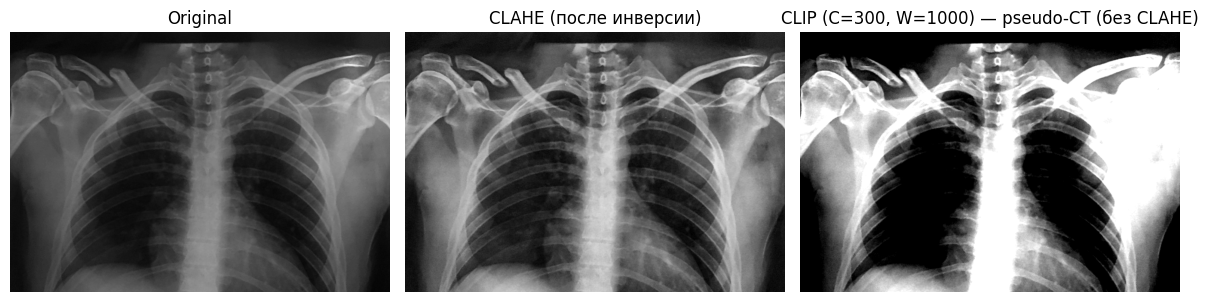

In [9]:
import requests
from PIL import Image

image_url = 'https://motogonki.ru/images/news/add201703241733262.jpg'
image = Image.open(requests.get(image_url, headers={"User-Agent": "example"}, stream=True).raw)

arr, fig = preprocess_xray_pil_v4(image, preset="clahe", visualize=True)

plt.show()

# Если нужен PyTorch-тензор (N,C,H,W):
import torch
x = torch.from_numpy(arr).permute(2,0,1).unsqueeze(0).float()  # shape: [1,3,512,512]


In [10]:
%%time

# 2) переводим обратно в PIL.Image
import numpy as np
from PIL import Image

def arr_to_pil(arr):
    if arr.ndim == 2:           # [H,W], 0..1
        u8 = (np.clip(arr, 0, 1) * 255).astype(np.uint8)
        return Image.fromarray(u8, mode="L")
    elif arr.ndim == 3 and arr.shape[2] == 3:  # [H,W,3], 0..1
        u8 = (np.clip(arr, 0, 1) * 255).astype(np.uint8)
        return Image.fromarray(u8, mode="RGB")
    else:
        raise ValueError("Unexpected array shape")

processed_pil = arr_to_pil(arr)

w, h = processed_pil.size
print("Width:", w, "Height:", h)

#    input image size width: {w}, height {h}.
prompt = f"""Task: detect clavicle fracture on AP chest radiograph.
Steps:
1) Check cortical continuity of both clavicles, especially the midshaft.
2) Look for cortical step-off, transverse/oblique lucent lines, and periosteal callus.
3) Compare left vs right for asymmetry, displacement, or angulation.
4) Output:
   - probability in [0,1],
   - side: left/right,
   - short justification,
   - explanation for selected in a next step bounding box, 
   - bounding box in pixels (x,y,w,h) with 99% confidence relative to the provided image,
Be concise."""

messages = [
    {"role": "system", "content": [{"type": "text", "text": "You are an expert radiologist."}]},
    {"role": "user", "content": [
        {"type": "text", "text": prompt},
        {"type": "image", "image": processed_pil},
    ]}
]

output = pipe(text=messages, max_new_tokens=256)
display(Markdown(output[0]["generated_text"][-1]["content"]))

Width: 970 Height: 663


```json
{
  "probability": 0.85,
  "side": "right",
  "short_justification": "Right clavicle shows cortical step-off and a possible fracture line in the midshaft.",
  "explanation": "The right clavicle appears to have a cortical step-off and a possible fracture line in the midshaft region. This is consistent with a clavicle fracture.",
  "bounding_box": [
    100,
    150,
    150,
    100
  ]
}
```

CPU times: user 10.5 s, sys: 166 ms, total: 10.6 s
Wall time: 10.6 s


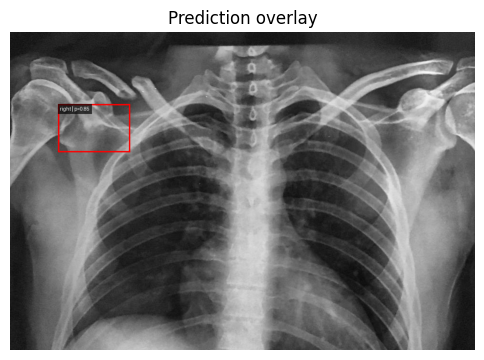

In [11]:
import json, re
from PIL import ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

def _extract_json_from_model(content):
    """
    Пытается достать JSON-объект из ответа модели.
    Поддерживает: dict уже, либо строку с JSON/код-блоком.
    """
    if isinstance(content, dict):
        return content
    if isinstance(content, list) and content and isinstance(content[-1], dict):
        return content[-1]  # на всякий
    if isinstance(content, str):
        # вытащим первый {...} блок
        m = re.search(r'\{.*\}', content, flags=re.S)
        if not m:
            raise ValueError("JSON object not found in model content")
        return json.loads(m.group(0))
    raise ValueError(f"Unsupported content type: {type(content)}")

def _clamp_bbox_to_image(bbox, w, h):
    """bbox: [x,y,w_,h_] -> обрезать в пределах изображения и вернуть [x1,y1,x2,y2]."""
    x, y, bw, bh = bbox
    x1 = max(0, int(round(x)))
    y1 = max(0, int(round(y)))
    x2 = min(w - 1, int(round(x + bw)))
    y2 = min(h - 1, int(round(y + bh)))
    # гарантируем, что минимум 1px
    x2 = max(x2, x1 + 1)
    y2 = max(y2, y1 + 1)
    return [x1, y1, x2, y2]

def draw_bbox_on_pil(pil_img, bbox, label=None, color=(255, 0, 0)):
    """
    Рисует прямоугольник и опциональную подпись на PIL.Image.
    Возвращает новый PIL.Image.
    """
    img = pil_img.convert("RGB").copy()
    draw = ImageDraw.Draw(img, "RGBA")

    w_img, h_img = img.size
    x1, y1, x2, y2 = _clamp_bbox_to_image(bbox, w_img, h_img)

    # прямоугольник
    draw.rectangle([x1, y1, x2, y2], outline=color, width=3)

    # полупрозрачная заливка поверх bbox с низкой альфой (если хочется)
    # draw.rectangle([x1, y1, x2, y2], fill=(color[0], color[1], color[2], 40))

    if label:
        # фон под текст
        try:
            # системный шрифт может отсутствовать в окружении — оставим дефолт
            font = ImageFont.load_default()
        except Exception:
            font = None
        text_w, text_h = draw.textbbox((0, 0), label, font=font)[2:]
        pad = 4
        bx2 = min(x1 + text_w + 2 * pad, w_img - 1)
        by2 = min(y1 + text_h + 2 * pad, h_img - 1)
        draw.rectangle([x1, y1, bx2, by2], fill=(0, 0, 0, 180))
        draw.text((x1 + pad, y1 + pad), label, fill=(255, 255, 255), font=font)

    return img

# 1) достанем контент последнего сообщения модели
model_content = output[0]["generated_text"][-1]["content"]

# 2) распарсим JSON (или достанем dict)
pred = _extract_json_from_model(model_content)

# 3) возьмём bbox/метки (с дефолтами на всякий)
bbox = pred.get("bounding_box", [0, 0, 10, 10])  # [x, y, w, h]
prob = pred.get("probability", None)
side = pred.get("side", None)

label_str = None
if prob is not None or side is not None:
    parts = []
    if side is not None:
        parts.append(f"{side}")
    if prob is not None:
        try:
            parts.append(f"p={float(prob):.2f}")
        except Exception:
            parts.append(f"p={prob}")
    label_str = " | ".join(parts)

# 4) нарисуем поверх того изображения, что подавали в модель (processed_pil)
overlay_img = draw_bbox_on_pil(processed_pil, bbox, label=label_str, color=(255, 0, 0))

# 5) отобразим
plt.figure(figsize=(6, 6))
plt.imshow(overlay_img)
plt.axis("off")
plt.title("Prediction overlay")
plt.show()


In [12]:
# %%time
# messages = [
#     {
#         "role": "system",
#         "content": [{"type": "text", "text": "You are an expert radiologist."}]
#     },
#     {
#         "role": "user",
#         "content": [
#             {"type": "text", "text": "analyze this RG for bone integrity"},
#             {"type": "image", "image": image},
#         ]
#     }
# ]

# output = pipe(text=messages, max_new_tokens=256)
# display(Markdown(output[0]["generated_text"][-1]["content"]))

# KT

In [7]:
def get_messages(image):
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are an expert radiologist."}]
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "return label normal/desease, desease if any anomaly is observed, return format - label: your decision"},
                {"type": "image", "image": image},
            ]
        }
    ]
    return messages

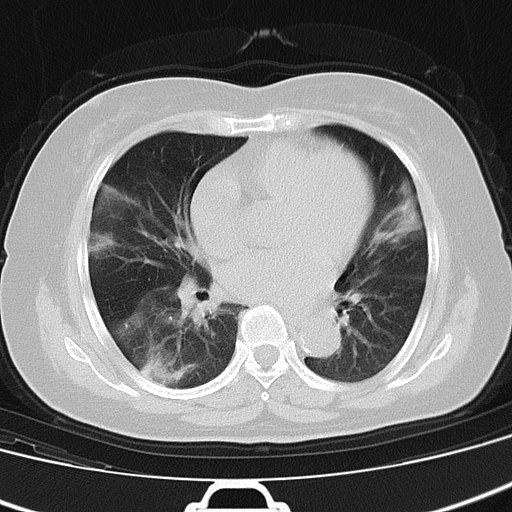

In [8]:
Image.open('/kaggle/input/covid19normalpneumonia-ct-images/COVID2_CT/25847 (18).jpg')

In [9]:
%%time
image_path = '/kaggle/input/covid19normalpneumonia-ct-images/COVID2_CT/25847 (18).jpg'
image = Image.open(image_path)
output = pipe(text=get_messages(image), max_new_tokens=256)
display(Markdown(output[0]["generated_text"][-1]["content"]))

label: desease


CPU times: user 2.18 s, sys: 114 ms, total: 2.29 s
Wall time: 2.25 s


In [46]:
import numpy as np
import pydicom
from PIL import Image

def _to_uint8(sl, ds):
    sl = sl.astype(np.float32)
    # применяем RescaleSlope/Intercept, если есть
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    inter  = float(getattr(ds, "RescaleIntercept", 0.0))
    if slope != 1.0 or inter != 0.0:
        sl = sl * slope + inter
    # простая контраст-нормализация по перцентилям
    lo, hi = np.percentile(sl, [1, 99])
    if hi <= lo: hi = lo + 1.0
    sl = np.clip((sl - lo) / (hi - lo), 0, 1)
    u8 = (sl * 255.0 + 0.5).astype(np.uint8)
    # инверсия для MONOCHROME1
    if str(getattr(ds, "PhotometricInterpretation", "")).upper() == "MONOCHROME1":
        u8 = 255 - u8
    return u8

def _center_block_indices(F, k):
    k = min(k, F)
    start = max(0, (F - k) // 2)
    end = start + k
    if end > F:
        start = F - k
        end = F
    return np.arange(start, end)

def _window_block_indices(F, k, frac_lo=0.4, frac_hi=0.6):
    lo = int(np.floor(F * frac_lo))
    hi = int(np.ceil (F * frac_hi))
    lo = max(0, min(lo, F))
    hi = max(lo+1, min(hi, F))
    window_len = hi - lo
    if k <= window_len:
        start = lo + (window_len - k)//2
        end = start + k
    else:
        # если k больше окна — вернём центральный блок по всему объёму
        return _center_block_indices(F, k)
    return np.arange(start, end)

def take_middle_slices(dcm_path, k=25, mode="window", frac_lo=0.4, frac_hi=0.6):
    """
    Возвращает список PIL.Image (uint8, 'L') и индексы выбранных слайсов.
    mode='center'  -> k подряд из геометрического центра
    mode='window'  -> k подряд из окна [frac_lo, frac_hi] по глубине
    """
    ds = pydicom.dcmread(dcm_path)
    vol = ds.pixel_array  # [F, H, W] для многокадрового DICOM
    assert vol.ndim == 3, "Ожидается многокадровый DICOM (3D)."
    F = vol.shape[0]

    if mode == "center":
        idx = _center_block_indices(F, k)
    else:
        idx = _window_block_indices(F, k, frac_lo, frac_hi)

    images = [Image.fromarray(_to_uint8(vol[i], ds), mode="L") for i in idx]
    return images, idx

# ==== примеры ====
dcm_path = "/kaggle/input/ldt-25-08-data/Датасет/pneumotorax_anon/10000CF6_anon"  # укажи точный файл

# 1) Ровно k из центра объёма:
imgs_center, idx_center = take_middle_slices(dcm_path, k=25, mode="center")

# 2) k из «серединного окна» 40–60% (как ты описал 40:60):
imgs_window, idx_window = take_middle_slices(dcm_path, k=25, mode="window", frac_lo=0.4, frac_hi=0.6)

# Прогон через твой pipe:
results = []
for im in imgs_window:
    out = pipe(text=get_messages(im), max_new_tokens=256)
    out = out[0]["generated_text"][-1]["content"]
    results.append(out)

results = pd.Series(results)
display(results.value_counts())

label: normal\n     21
label: desease\n     4
Name: count, dtype: int64

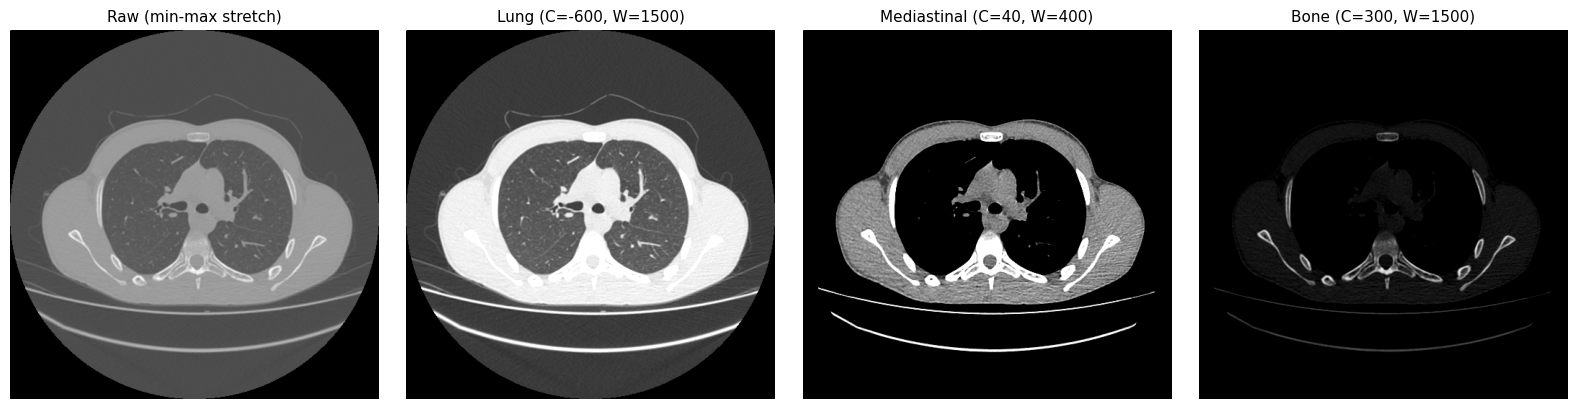

In [26]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt

def _to_hu(ds):
    """Преобразование сырых значений в HU с учётом RescaleSlope/Intercept."""
    arr = ds.pixel_array.astype(np.float32)
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    inter = float(getattr(ds, "RescaleIntercept", 0.0))
    return arr * slope + inter

def _apply_window(hu, center, width):
    """Клиппинг по окну + нормализация в [0,1]."""
    lo = center - width / 2.0
    hi = center + width / 2.0
    img = np.clip(hu, lo, hi)
    return (img - lo) / (hi - lo + 1e-6)

def _normalize_minmax(hu):
    """Простая нормализация всего диапазона HU (без окна)."""
    lo, hi = hu.min(), hu.max()
    img = (hu - lo) / (hi - lo + 1e-6)
    return img

def visualize_ct_windows(dcm_path, frame=None):
    """
    Отобразить один DICOM в трёх окнах + без обрезки.
    """
    ds = pydicom.dcmread(dcm_path)
    hu = _to_hu(ds)

    # если многокадровый DICOM (3D: [F,H,W])
    if hu.ndim == 3:
        F = hu.shape[0]
        idx = F // 2 if frame is None else int(np.clip(frame, 0, F-1))
        hu = hu[idx]

    # инверсия, если MONOCHROME1
    if str(getattr(ds, "PhotometricInterpretation", "")).upper() == "MONOCHROME1":
        hu = -hu

    windows = {
        "Raw (min-max stretch)": None,             # без обрезки
        "Lung (C=-600, W=1500)":  (-600, 1500),
        "Mediastinal (C=40, W=400)": (40, 400),
        "Bone (C=300, W=1500)":   (700, 1500),
    }

    plt.figure(figsize=(16, 4))
    for i, (name, win) in enumerate(windows.items(), 1):
        if win is None:
            img = _normalize_minmax(hu)
        else:
            img = _apply_window(hu, *win)
        ax = plt.subplot(1, 4, i)
        ax.imshow(img, cmap="gray", vmin=0.0, vmax=1.0)
        ax.set_title(name, fontsize=11)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# пример:
# visualize_ct_windows("/kaggle/input/ldt-25-08-data/Датасет/pneumotorax_anon/10000CF6_....")
# для конкретного кадра многокадрового DICOM:
visualize_ct_windows("/kaggle/input/ldt-25-08-data/Датасет/norma_anon/10000F19_anon", frame=50)


In [45]:
%%time
import pydicom
import matplotlib.pyplot as plt

folder = '/kaggle/input/ldt-25-08-data/Датасет/norma_anon'
for root, dirs, files in  os.walk(folder):
    # samples = pd.Series(sorted(files)).sample(25).values
    n_samples = len(files)
    bot  = int(n_samples * 0.1)
    top  = int(n_samples * 0.9)
    step = 7 
    samples = pd.Series(files).iloc[range(bot,top,step)].values
    result = []
    for sample in samples:
        ds = pydicom.dcmread(folder+'/'+sample)
        img = ds.pixel_array
        img = (img / img.max() * 255).astype("uint8")
        image = Image.fromarray(img)
        prompt = """
        Task: classify chest CT scan for pulmonary abnormalities.
        Steps:
        1) Examine both lungs for opacities, consolidations, ground-glass changes, pleural effusion, pneumothorax, fibrosis, or nodules.
        2) If no abnormalities are visible, output label: normal.
        3) If any abnormality is suspected, output label: anomaly.
        4) Output format:
           - label: normal OR label: anomaly
        """

        messages_test = [
            {
                "role": "system",
                "content": [{"type": "text", "text": "You are an expert radiologist."}]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "image": image},
                ]
            }
        ]
        
        output = pipe(text=messages_test, max_new_tokens=256)
        output = output[0]["generated_text"][-1]["content"]
        # print(output)
        result.append(output)
    result = pd.Series(result)
    display(pd.Series([x.split(':')[1].split('\n')[0] for x in result]).value_counts())

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


normal     48
anomaly     4
Name: count, dtype: int64

CPU times: user 1min 54s, sys: 8.72 s, total: 2min 2s
Wall time: 2min 2s


In [46]:
%%time
import pydicom
import matplotlib.pyplot as plt

folder = '/kaggle/input/ldt-25-08-data/Датасет/pneumonia_anon'
for root, dirs, files in  os.walk(folder):
    # samples = pd.Series(sorted(files)).sample(25).values
    n_samples = len(files)
    bot  = int(n_samples * 0.1)
    top  = int(n_samples * 0.9)
    step = 7 
    samples = pd.Series(files).iloc[range(bot,top,step)].values
    result = []
    for sample in samples:
        ds = pydicom.dcmread(folder+'/'+sample)
        img = ds.pixel_array
        img = (img / img.max() * 255).astype("uint8")
        image = Image.fromarray(img)
        prompt = """
        Task: classify chest CT scan for pulmonary abnormalities.
        Steps:
        1) Examine both lungs for opacities, consolidations, ground-glass changes, pleural effusion, pneumothorax, fibrosis, or nodules.
        2) If no abnormalities are visible, output label: normal.
        3) If any abnormality is suspected, output label: anomaly.
        4) Output format:
           - label: normal OR label: anomaly
        """

        messages_test = [
            {
                "role": "system",
                "content": [{"type": "text", "text": "You are an expert radiologist."}]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "image": image},
                ]
            }
        ]
        
        output = pipe(text=messages_test, max_new_tokens=256)
        output = output[0]["generated_text"][-1]["content"]
        # print(output)
        result.append(output)
    result = pd.Series(result)
    display(pd.Series([x.split(':')[1].split('\n')[0] for x in result]).value_counts())

normal     30
anomaly    12
Name: count, dtype: int64

CPU times: user 1min 32s, sys: 6.98 s, total: 1min 39s
Wall time: 1min 38s


In [52]:
%%time
import os, numpy as np, pandas as pd
import pydicom
from PIL import Image
import matplotlib.pyplot as plt

# ====== Настройка шага для выборки срезов ======
# По краям (1-й и 4-й квартили) берём шагом n,
# в середине (2-й и 3-й квартили) — шагом n//2 (минимум 1)
n = 8  # <- при необходимости измените

def quartile_sample_indices(n_files: int, n: int):
    """
    Возвращает индексы по правилу:
    - Q1 [0, q1):     шаг n
    - Q2 [q1, q2):    шаг n//2
    - Q3 [q2, q3):    шаг n//2
    - Q4 [q3, N):     шаг n
    """
    if n_files <= 0:
        return []
    q1 = n_files // 4
    q2 = n_files // 2
    q3 = (3 * n_files) // 4
    step_outer = max(1, int(n))
    step_inner = max(1, step_outer // 2)  # чтобы не получить 0

    idx = (
        list(range(0,   q1, step_outer)) +
        list(range(q1,  q2, step_inner)) +
        list(range(q2,  q3, step_inner)) +
        list(range(q3, n_files, step_outer))
    )

    # Мягкая дедупликация только если границы совпали,
    # с сохранением исходного порядка:
    seen = set()
    dedup_idx = []
    for i in idx:
        if 0 <= i < n_files and i not in seen:
            seen.add(i)
            dedup_idx.append(i)
    return dedup_idx


# ====== Вспомогательные функции для CT предобработки (Lung) ======
def _to_hu(ds):
    """Преобразование сырых значений в HU с учётом RescaleSlope/Intercept."""
    arr = ds.pixel_array.astype(np.float32)
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    inter = float(getattr(ds, "RescaleIntercept", 0.0))
    return arr * slope + inter

def _apply_window(hu, center, width):
    """Клиппинг по окну + нормализация в [0,1]."""
    lo = center - width / 2.0
    hi = center + width / 2.0
    img = np.clip(hu, lo, hi)
    return (img - lo) / (hi - lo + 1e-6)

def to_lung_window_pil(ds):
    """
    Возвращает PIL.Image для одного DICOM кадра в Lung окне:
    - Перевод в HU
    - Если многокадровый DICOM, берём центральный кадр
    - Инвертируем при MONOCHROME1
    - Окно Lung: C=-600, W=1500
    - Конвертация в uint8 [0..255]
    """
    hu = _to_hu(ds)

    # Если многокадровый DICOM (3D: [F,H,W]) — берём центральный кадр
    if hu.ndim == 3:
        F = hu.shape[0]
        hu = hu[F // 2]

    # Инверсия, если MONOCHROME1
    if str(getattr(ds, "PhotometricInterpretation", "")).upper() == "MONOCHROME1":
        hu = -hu

    img01 = _apply_window(hu, center=-600, width=1500)  # Lung
    u8 = (img01 * 255.0).clip(0, 255).astype(np.uint8)
    return Image.fromarray(u8, mode="L")

# ====== Основной цикл ======
folder = '/kaggle/input/ldt-25-08-data/Датасет/norma_anon'
for root, dirs, files in os.walk(folder):
    # Сортируем список файлов для устойчивой индексации
    files_sorted = sorted([f for f in files if not f.startswith('.')])
    n_files = len(files_sorted)

    # Выбор индексов по квантильному правилу
    idx = quartile_sample_indices(n_files, n=n)
    samples = pd.Series([files_sorted[i] for i in idx]).values

    result = []
    for sample in samples:
        ds = pydicom.dcmread(os.path.join(folder, sample))

        # === ВАЖНО ===
        # Предобработка изображения по логике "Lung" вместо простого min-max:
        image = to_lung_window_pil(ds)

        prompt = """
        Task: classify chest CT scan for pulmonary abnormalities.
        Steps:
        1) Examine both lungs for opacities, consolidations, ground-glass changes, pleural effusion, pneumothorax, fibrosis, or nodules.
        2) If no abnormalities are visible, output label: normal.
        3) If any abnormality is suspected, output label: anomaly.
        4) Output format:
           - label: normal OR label: anomaly
        """

        messages_test = [
            {
                "role": "system",
                "content": [{"type": "text", "text": "You are an expert radiologist."}]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "image": image},
                ]
            }
        ]

        output = pipe(text=messages_test, max_new_tokens=256)
        output = output[0]["generated_text"][-1]["content"]
        result.append(output)

    result = pd.Series(result)
    display(pd.Series([x.split(':')[1].split('\n')[0] for x in result]).value_counts())


normal     81
anomaly     6
Name: count, dtype: int64

CPU times: user 3min 9s, sys: 14.7 s, total: 3min 24s
Wall time: 3min 20s


In [51]:
%%time
import os, numpy as np, pandas as pd
import pydicom
from PIL import Image
import matplotlib.pyplot as plt

# ====== Настройка шага для выборки срезов ======
# По краям (1-й и 4-й квартили) берём шагом n,
# в середине (2-й и 3-й квартили) — шагом n//2 (минимум 1)
n = 8  # <- при необходимости измените

def quartile_sample_indices(n_files: int, n: int):
    """
    Возвращает индексы по правилу:
    - Q1 [0, q1):     шаг n
    - Q2 [q1, q2):    шаг n//2
    - Q3 [q2, q3):    шаг n//2
    - Q4 [q3, N):     шаг n
    """
    if n_files <= 0:
        return []
    q1 = n_files // 4
    q2 = n_files // 2
    q3 = (3 * n_files) // 4
    step_outer = max(1, int(n))
    step_inner = max(1, step_outer // 2)  # чтобы не получить 0

    idx = (
        list(range(0,   q1, step_outer)) +
        list(range(q1,  q2, step_inner)) +
        list(range(q2,  q3, step_inner)) +
        list(range(q3, n_files, step_outer))
    )

    # Мягкая дедупликация только если границы совпали,
    # с сохранением исходного порядка:
    seen = set()
    dedup_idx = []
    for i in idx:
        if 0 <= i < n_files and i not in seen:
            seen.add(i)
            dedup_idx.append(i)
    return dedup_idx


# ====== Вспомогательные функции для CT предобработки (Lung) ======
def _to_hu(ds):
    """Преобразование сырых значений в HU с учётом RescaleSlope/Intercept."""
    arr = ds.pixel_array.astype(np.float32)
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    inter = float(getattr(ds, "RescaleIntercept", 0.0))
    return arr * slope + inter

def _apply_window(hu, center, width):
    """Клиппинг по окну + нормализация в [0,1]."""
    lo = center - width / 2.0
    hi = center + width / 2.0
    img = np.clip(hu, lo, hi)
    return (img - lo) / (hi - lo + 1e-6)

def to_lung_window_pil(ds):
    """
    Возвращает PIL.Image для одного DICOM кадра в Lung окне:
    - Перевод в HU
    - Если многокадровый DICOM, берём центральный кадр
    - Инвертируем при MONOCHROME1
    - Окно Lung: C=-600, W=1500
    - Конвертация в uint8 [0..255]
    """
    hu = _to_hu(ds)

    # Если многокадровый DICOM (3D: [F,H,W]) — берём центральный кадр
    if hu.ndim == 3:
        F = hu.shape[0]
        hu = hu[F // 2]

    # Инверсия, если MONOCHROME1
    if str(getattr(ds, "PhotometricInterpretation", "")).upper() == "MONOCHROME1":
        hu = -hu

    img01 = _apply_window(hu, center=-600, width=1500)  # Lung
    u8 = (img01 * 255.0).clip(0, 255).astype(np.uint8)
    return Image.fromarray(u8, mode="L")

# ====== Основной цикл ======
folder = '/kaggle/input/ldt-25-08-data/Датасет/pneumonia_anon'
for root, dirs, files in os.walk(folder):
    # Сортируем список файлов для устойчивой индексации
    files_sorted = sorted([f for f in files if not f.startswith('.')])
    n_files = len(files_sorted)

    # Выбор индексов по квантильному правилу
    idx = quartile_sample_indices(n_files, n=n)
    samples = pd.Series([files_sorted[i] for i in idx]).values

    result = []
    for sample in samples:
        ds = pydicom.dcmread(os.path.join(folder, sample))

        # === ВАЖНО ===
        # Предобработка изображения по логике "Lung" вместо простого min-max:
        image = to_lung_window_pil(ds)

        prompt = """
        Task: classify chest CT scan for pulmonary abnormalities.
        Steps:
        1) Examine both lungs for opacities, consolidations, ground-glass changes, pleural effusion, pneumothorax, fibrosis, or nodules.
        2) If no abnormalities are visible, output label: normal.
        3) If any abnormality is suspected, output label: anomaly.
        4) Output format:
           - label: normal OR label: anomaly
        """

        messages_test = [
            {
                "role": "system",
                "content": [{"type": "text", "text": "You are an expert radiologist."}]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "image": image},
                ]
            }
        ]

        output = pipe(text=messages_test, max_new_tokens=256)
        output = output[0]["generated_text"][-1]["content"]
        result.append(output)

    result = pd.Series(result)
    display(pd.Series([x.split(':')[1].split('\n')[0] for x in result]).value_counts())


normal     50
anomaly    20
Name: count, dtype: int64

CPU times: user 2min 32s, sys: 11.8 s, total: 2min 44s
Wall time: 2min 41s


In [42]:
%%time
import pydicom
import matplotlib.pyplot as plt

prompt = """
Task: classify chest CT scan for pulmonary abnormalities.
Steps:
1) Examine both lungs for opacities, consolidations, ground-glass changes, pleural effusion, pneumothorax, fibrosis, or nodules.
2) If no abnormalities are visible, output label: normal.
3) If any abnormality is suspected, output label: anomaly and provide a short justification.
4) Output format:
   - label: normal OR label: anomaly
   - (if anomaly) short justification
Be concise.
"""



ds = pydicom.dcmread('/kaggle/input/ldt-25-08-data/Датасет/pneumonia_anon/100003DD_anon')
img = ds.pixel_array
img = (img / img.max() * 255).astype("uint8")
image = Image.fromarray(img)

messages_test = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are an expert radiologist."}]
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image", "image": image},
            ]
        }
    ]


output = pipe(text=messages_test, max_new_tokens=256)
output = output[0]["generated_text"][-1]["content"]
output

CPU times: user 2.28 s, sys: 162 ms, total: 2.44 s
Wall time: 2.39 s


'- label: normal\n'

In [41]:
print(output)

- probability of abnormality in 0.0
- type(s) of abnormality none
- short justification The image shows a normal cross-section of the chest with clear lung fields and no obvious abnormalities.
- bounding box or slice range in pixels (x,y,w,h or slice indices) None



# KT COVID eval

In [ ]:
df_covid = pd.read_excel('/kaggle/input/mosmeddata-chest-ct-scans-with-covid19/MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0/dataset_registry.xlsx')
df_covid.head()

In [ ]:
import nibabel as nib
import numpy as np
from PIL import Image

# читаем NIfTI
nii_path = "/kaggle/input/mosmeddata-chest-ct-scans-with-covid19/MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0/studies/CT-0/study_0001.nii"
nii = nib.load(nii_path)
arr = nii.get_fdata()  # numpy.ndarray [Z,H,W] или [H,W,Z]

print("Shape:", arr.shape)

# допустим, ось срезов — первая
n_slices = arr.shape[0]

# получаем индексы по вашему правилу
n = 8
indices = quartile_sample_indices(n_slices, n)

# делаем PIL.Image для выбранных срезов
images = []
for i in indices:
    slice_2d = arr[i]  # [H,W]
    slice_norm = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min() + 1e-6)
    u8 = (slice_norm * 255).astype(np.uint8)
    images.append(Image.fromarray(u8, mode="L"))

print("Выбрано срезов:", len(images))
images[0].show()  # пример


In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

nii = nib.load("/kaggle/input/mosmeddata-chest-ct-scans-with-covid19/MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0/studies/CT-0/study_0001.nii")
arr = nii.get_fdata()  # [Z,H,W]

print("Shape:", arr.shape)


In [ ]:
import matplotlib.pyplot as plt

nii_slice = arr[:, :, 20]  # берем 20-й срез по 3-й оси
plt.imshow(nii_slice.T, cmap="gray", origin="lower")  # .T и origin для правильной ориентации
plt.axis("off")
plt.show()


In [ ]:
# hdr = nii.header
# print(hdr)

In [17]:
import os
import random
import numpy as np
import pandas as pd
import nibabel as nib
from PIL import Image
from tqdm import tqdm

# === функции ===
def select_step(n_slices: int) -> int:
    """Определяем шаг n в зависимости от числа срезов."""
    if n_slices < 50:
        return 1
    elif n_slices < 100:
        return 2
    elif n_slices < 200:
        return 4
    elif n_slices < 400:
        return 6
    else:
        return 8

def load_slices_from_nii(path: str):
    """Загрузить nii и вернуть список PIL.Image для выбранных срезов."""
    nii = nib.load(path)
    arr = nii.get_fdata()
    shape = arr.shape
    # предполагаем, что третья ось = срезы
    n_slices = shape[2]
    step = select_step(n_slices)

    indices = range(0, n_slices, step)
    images = []
    for i in indices:
        slice_2d = arr[:, :, i]
        # нормализация в [0,255]
        slice_norm = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min() + 1e-6)
        u8 = (slice_norm * 255).astype(np.uint8)
        images.append(Image.fromarray(u8, mode="L"))
    return images, n_slices, len(indices)

def classify_images(images, pipe, prompt):
    """Прогон через модель список PIL.Image, возвращает счетчики."""
    counts = {"normal": 0, "anomaly": 0}
    for image in images:
        messages_test = [
            {
                "role": "system",
                "content": [{"type": "text", "text": "You are an expert radiologist."}]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "image": image},
                ]
            }
        ]
        output = pipe(text=messages_test, max_new_tokens=256)
        text = output[0]["generated_text"][-1]["content"]
        try:
            label = text.split(":")[1].split("\n")[0].strip().lower()
            if label in counts:
                counts[label] += 1
        except:
            pass
    return counts

# === основной код ===
base_dir = "/kaggle/input/mosmeddata-chest-ct-scans-with-covid19/MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0/studies"
folders = [f"CT-{i}" for i in range(5)]

prompt = """
Task: classify chest CT scan for pulmonary abnormalities.
Steps:
1) Examine both lungs for opacities, consolidations, ground-glass changes, pleural effusion, pneumothorax, fibrosis, or nodules.
2) If no abnormalities are visible, output label: normal.
3) If any abnormality is suspected, output label: anomaly.
4) Output format:
   - label: normal OR label: anomaly
"""

results = []

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    all_files = [f for f in os.listdir(folder_path) if f.endswith(".nii")]
    # if folder == 'CT-0':
    #     selected_files = random.sample(all_files, min(25, len(all_files)))
    # else:
    #     selected_files = random.sample(all_files, min(5, len(all_files)))
    ## selected_files = random.sample(all_files, min(10, len(all_files)))
    if folder == 'CT-0':
        selected_files = all_files[:25]
    else:
        selected_files = all_files[:min([5, len(all_files)])]
        

    for fname in tqdm(selected_files, desc=f"Processing {folder}"):
        path = os.path.join(folder_path, fname)

        # 1. загружаем срезы
        images, n_slices, n_used = load_slices_from_nii(path)

        # 2. классификация
        counts = classify_images(images, pipe, prompt)

        # 3. запись результата
        results.append({
            "study_id": fname,
            "folder": folder,
            "n_slices": n_slices,
            "n_used": n_used,
            "count_normal": counts["normal"],
            "count_anomaly": counts["anomaly"]
        })

# итоговая таблица
df_results = pd.DataFrame(results)
display(df_results)


Processing CT-4: 100%|██████████| 2/2 [03:08<00:00, 94.03s/it] 


study_id folder  n_slices  n_used  count_normal  count_anomaly
0   study_0061.nii   CT-0        43      43            40              2
1   study_0089.nii   CT-0        38      38            36              2
2   study_0112.nii   CT-0        41      41            41              0
3   study_0144.nii   CT-0        35      35            35              0
4   study_0146.nii   CT-0        45      45            45              0
5   study_0189.nii   CT-0        48      48            46              2
6   study_0138.nii   CT-0        40      40            35              5
7   study_0035.nii   CT-0        46      46            38              8
8   study_0087.nii   CT-0        45      45            43              2
9   study_0183.nii   CT-0        48      48            45              3
10  study_0198.nii   CT-0        45      45            45              0
11  study_0085.nii   CT-0        41      41            41              0
12  study_0165.nii   CT-0        45      45            44              1
13  study_0197.nii   CT-0        45      45            44              1
14  study_0106.nii   CT-0        45      45            43              2
15  study_0038.nii   CT-0        48      48            47              1
16  study_0188.nii   CT-0        48      48            47              1
17  study_0143.nii   CT-0        45      45            45              0
18  study_0129.nii   CT-0        45      45            45              0
19  study_0148.nii   CT-0        45      45            44              1
20  study_0058.nii   CT-0        43      43            38              5
21  study_0204.nii   CT-0        49      49            44              5
22  study_0218.nii   CT-0        51      26            22              3
23  study_0193.nii   CT-0        51      26            24              2
24  study_0223.nii   CT-0        45      45            42              3
25  study_0367.nii   CT-1        37      37            30              7
26  study_0704.nii   CT-1        36      36            36              0
27  study_0298.nii   CT-1        43      43            40              3
28  study_0523.nii   CT-1        41      41            37              4
29  study_0926.nii   CT-1        53      27            25              2
30  study_0994.nii   CT-2        40      40            31              9
31  study_0957.nii   CT-2        36      36            22             14
32  study_1047.nii   CT-2        45      45            28             17
33  study_0992.nii   CT-2        36      36            30              6
34  study_1032.nii   CT-2        46      46            36             10
35  study_1085.nii   CT-3        42      42            25             17
36  study_1080.nii   CT-3        38      38            30              8
37  study_1090.nii   CT-3        45      45            24             21
38  study_1065.nii   CT-3        45      45            37              8
39  study_1081.nii   CT-3        34      34            30              4
40  study_1110.nii   CT-4        42      42            19             23
41  study_1109.nii   CT-4        36      36            30              6

In [16]:
df_results['anomaly_share'] = df_results['count_anomaly']/(df_results['count_anomaly'] + df_results['count_normal'])

In [17]:
df_results.groupby(by='folder')['anomaly_share'].agg('mean')

folder
CT-0    0.047298
CT-1    0.086118
CT-2    0.275145
CT-3    0.275476
CT-4    0.357143
Name: anomaly_share, dtype: float64

In [18]:
df_results_raw = df_results.copy()

In [13]:
# import pandas as pd

# data = [
#     (0,"study_0061.nii","CT-0",43,43,40,2),
#     (1,"study_0089.nii","CT-0",38,38,36,2),
#     (2,"study_0112.nii","CT-0",41,41,41,0),
#     (3,"study_0144.nii","CT-0",35,35,35,0),
#     (4,"study_0146.nii","CT-0",45,45,45,0),
#     (5,"study_0189.nii","CT-0",48,48,46,2),
#     (6,"study_0138.nii","CT-0",40,40,35,5),
#     (7,"study_0035.nii","CT-0",46,46,38,8),
#     (8,"study_0087.nii","CT-0",45,45,43,2),
#     (9,"study_0183.nii","CT-0",48,48,45,3),
#     (10,"study_0198.nii","CT-0",45,45,45,0),
#     (11,"study_0085.nii","CT-0",41,41,41,0),
#     (12,"study_0165.nii","CT-0",45,45,44,1),
#     (13,"study_0197.nii","CT-0",45,45,44,1),
#     (14,"study_0106.nii","CT-0",45,45,43,2),
#     (15,"study_0038.nii","CT-0",48,48,47,1),
#     (16,"study_0188.nii","CT-0",48,48,47,1),
#     (17,"study_0143.nii","CT-0",45,45,45,0),
#     (18,"study_0129.nii","CT-0",45,45,45,0),
#     (19,"study_0148.nii","CT-0",45,45,44,1),
#     (20,"study_0058.nii","CT-0",43,43,38,5),
#     (21,"study_0204.nii","CT-0",49,49,44,5),
#     (22,"study_0218.nii","CT-0",51,26,22,3),
#     (23,"study_0193.nii","CT-0",51,26,24,2),
#     (24,"study_0223.nii","CT-0",45,45,42,3),
#     (25,"study_0367.nii","CT-1",37,37,30,7),
#     (26,"study_0704.nii","CT-1",36,36,36,0),
#     (27,"study_0298.nii","CT-1",43,43,40,3),
#     (28,"study_0523.nii","CT-1",41,41,37,4),
#     (29,"study_0926.nii","CT-1",53,27,25,2),
#     (30,"study_0994.nii","CT-2",40,40,31,9),
#     (31,"study_0957.nii","CT-2",36,36,22,14),
#     (32,"study_1047.nii","CT-2",45,45,28,17),
#     (33,"study_0992.nii","CT-2",36,36,30,6),
#     (34,"study_1032.nii","CT-2",46,46,36,10),
#     (35,"study_1085.nii","CT-3",42,42,25,17),
#     (36,"study_1080.nii","CT-3",38,38,30,8),
#     (37,"study_1090.nii","CT-3",45,45,24,21),
#     (38,"study_1065.nii","CT-3",45,45,37,8),
#     (39,"study_1081.nii","CT-3",34,34,30,4),
#     (40,"study_1110.nii","CT-4",42,42,19,23),
#     (41,"study_1109.nii","CT-4",36,36,30,6),
# ]

# df_results = pd.DataFrame(data, columns=[
#     "id","study_id","folder","n_slices","n_used","count_normal","count_anomaly"
# ])

# print(df_results.head())


   id        study_id folder  n_slices  n_used  count_normal  count_anomaly
0   0  study_0061.nii   CT-0        43      43            40              2
1   1  study_0089.nii   CT-0        38      38            36              2
2   2  study_0112.nii   CT-0        41      41            41              0
3   3  study_0144.nii   CT-0        35      35            35              0
4   4  study_0146.nii   CT-0        45      45            45              0


In [19]:
from sklearn.metrics import roc_auc_score
df_results_raw['target'] = 1
df_results_raw.loc[df_results_raw['folder'] == 'CT-0', 'target'] = 0
print(roc_auc_score(df_results_raw.target, df_results_raw.anomaly_share))

0.8976470588235292


In [21]:
from sklearn.metrics import precision_recall_fscore_support

y_true = df_results_raw["target"].values
y_score = df_results_raw["anomaly_share"].values

best_f1, best_thr, best_prec, best_rec = 0, None, None, None

for thr in np.linspace(0, 1, 101):  # перебор порогов от 0 до 1
    y_pred = (y_score >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr, best_prec, best_rec = f1, thr, prec, rec

print(f"Best threshold: {best_thr:.2f}")
print(f"Precision: {best_prec:.3f}, Recall: {best_rec:.3f}, F1: {best_f1:.3f}")


Best threshold: 0.13
Precision: 0.923, Recall: 0.706, F1: 0.800


### добавим clip

In [13]:
def _apply_window(hu, center, width):
    """Клиппинг по окну + нормализация в [0,1]."""
    lo = center - width / 2.0
    hi = center + width / 2.0
    img = np.clip(hu, lo, hi)
    return (img - lo) / (hi - lo + 1e-6)

def load_slices_from_nii(path: str):
    """
    Загружаем .nii, берём срезы по правилу выбора шага,
    применяем Lung window (C=-600, W=1500),
    возвращаем список PIL.Image + количество срезов + количество выбранных.
    """
    nii = nib.load(path)
    arr = nii.get_fdata()
    shape = arr.shape
    n_slices = shape[2]  # третья ось = глубина
    step = select_step(n_slices)

    indices = range(0, n_slices, step)
    images = []
    for i in indices:
        slice_2d = arr[:, :, i]

        # применяем Lung window
        lung_img = _apply_window(slice_2d, center=-600, width=1500)

        # в uint8 для PIL
        u8 = (lung_img * 255.0).astype(np.uint8)
        images.append(Image.fromarray(u8, mode="L"))

    return images, n_slices, len(indices)

import os
import random
import numpy as np
import pandas as pd
import nibabel as nib
from PIL import Image
from tqdm import tqdm

# === функции ===
def select_step(n_slices: int) -> int:
    """Определяем шаг n в зависимости от числа срезов."""
    if n_slices < 50:
        return 1
    elif n_slices < 100:
        return 2
    elif n_slices < 200:
        return 4
    elif n_slices < 400:
        return 6
    else:
        return 8

def classify_images(images, pipe, prompt):
    """Прогон через модель список PIL.Image, возвращает счетчики."""
    counts = {"normal": 0, "anomaly": 0}
    for image in images:
        messages_test = [
            {
                "role": "system",
                "content": [{"type": "text", "text": "You are an expert radiologist."}]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "image": image},
                ]
            }
        ]
        output = pipe(text=messages_test, max_new_tokens=256)
        text = output[0]["generated_text"][-1]["content"]
        try:
            label = text.split(":")[1].split("\n")[0].strip().lower()
            if label in counts:
                counts[label] += 1
        except:
            pass
    return counts

# === основной код ===
base_dir = "/kaggle/input/mosmeddata-chest-ct-scans-with-covid19/MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0/studies"
folders = [f"CT-{i}" for i in range(5)]

prompt = """
Task: classify chest CT scan for pulmonary abnormalities.
Steps:
1) Examine both lungs for opacities, consolidations, ground-glass changes, pleural effusion, pneumothorax, fibrosis, or nodules.
2) If no abnormalities are visible, output label: normal.
3) If any abnormality is suspected, output label: anomaly.
4) Output format:
   - label: normal OR label: anomaly
"""

results = []

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    all_files = [f for f in os.listdir(folder_path) if f.endswith(".nii")]
    # if folder == 'CT-0':
    #     selected_files = random.sample(all_files, min(25, len(all_files)))
    # else:
    #     selected_files = random.sample(all_files, min(5, len(all_files)))
    ## selected_files = [x for x in all_files if x in df_results_raw.study_id.values]
    if folder == 'CT-0':
        selected_files = all_files[:25]
    else:
        selected_files = all_files[:min([5, len(all_files)])]

    for fname in tqdm(selected_files, desc=f"Processing {folder}"):
        path = os.path.join(folder_path, fname)

        # 1. загружаем срезы
        images, n_slices, n_used = load_slices_from_nii(path)

        # 2. классификация
        counts = classify_images(images, pipe, prompt)

        # 3. запись результата
        results.append({
            "study_id": fname,
            "folder": folder,
            "n_slices": n_slices,
            "n_used": n_used,
            "count_normal": counts["normal"],
            "count_anomaly": counts["anomaly"]
        })

# итоговая таблица
df_results = pd.DataFrame(results)
display(df_results)



Processing CT-4: 100%|██████████| 2/2 [03:00<00:00, 90.48s/it]


study_id folder  n_slices  n_used  count_normal  count_anomaly
0   study_0061.nii   CT-0        43      43            40              3
1   study_0089.nii   CT-0        38      38            37              1
2   study_0112.nii   CT-0        41      41            41              0
3   study_0144.nii   CT-0        35      35            35              0
4   study_0146.nii   CT-0        45      45            45              0
5   study_0189.nii   CT-0        48      48            45              3
6   study_0138.nii   CT-0        40      40            40              0
7   study_0035.nii   CT-0        46      46            44              2
8   study_0087.nii   CT-0        45      45            43              2
9   study_0183.nii   CT-0        48      48            44              4
10  study_0198.nii   CT-0        45      45            45              0
11  study_0085.nii   CT-0        41      41            38              3
12  study_0165.nii   CT-0        45      45            45              0
13  study_0197.nii   CT-0        45      45            44              1
14  study_0106.nii   CT-0        45      45            45              0
15  study_0038.nii   CT-0        48      48            48              0
16  study_0188.nii   CT-0        48      48            47              1
17  study_0143.nii   CT-0        45      45            45              0
18  study_0129.nii   CT-0        45      45            45              0
19  study_0148.nii   CT-0        45      45            43              2
20  study_0058.nii   CT-0        43      43            36              7
21  study_0204.nii   CT-0        49      49            41              8
22  study_0218.nii   CT-0        51      26            24              2
23  study_0193.nii   CT-0        51      26            24              2
24  study_0223.nii   CT-0        45      45            40              5
25  study_0367.nii   CT-1        37      37            32              5
26  study_0704.nii   CT-1        36      36            35              1
27  study_0298.nii   CT-1        43      43            41              2
28  study_0523.nii   CT-1        41      41            35              6
29  study_0926.nii   CT-1        53      27            25              2
30  study_0994.nii   CT-2        40      40            30             10
31  study_0957.nii   CT-2        36      36            22             14
32  study_1047.nii   CT-2        45      45            29             16
33  study_0992.nii   CT-2        36      36            32              4
34  study_1032.nii   CT-2        46      46            34             12
35  study_1085.nii   CT-3        42      42            28             14
36  study_1080.nii   CT-3        38      38            30              8
37  study_1090.nii   CT-3        45      45            19             26
38  study_1065.nii   CT-3        45      45            36              9
39  study_1081.nii   CT-3        34      34            29              5
40  study_1110.nii   CT-4        42      42            18             24
41  study_1109.nii   CT-4        36      36            33              3

In [14]:
df_results['anomaly_share'] = df_results['count_anomaly']/(df_results['count_anomaly'] + df_results['count_normal'])
df_results.groupby(by='folder')['anomaly_share'].agg('mean')

folder
CT-0    0.043261
CT-1    0.085968
CT-2    0.273285
CT-3    0.293739
CT-4    0.327381
Name: anomaly_share, dtype: float64

In [15]:
from sklearn.metrics import roc_auc_score
df_results['target'] = 1
df_results.loc[df_results['folder'] == 'CT-0', 'target'] = 0
print(roc_auc_score(df_results.target, df_results.anomaly_share))

0.908235294117647


In [16]:
from sklearn.metrics import precision_recall_fscore_support

y_true = df_results["target"].values
y_score = df_results["anomaly_share"].values

best_f1, best_thr, best_prec, best_rec = 0, None, None, None

for thr in np.linspace(0, 1, 101):  # перебор порогов от 0 до 1
    y_pred = (y_score >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr, best_prec, best_rec = f1, thr, prec, rec

print(f"Best threshold: {best_thr:.2f}")
print(f"Precision: {best_prec:.3f}, Recall: {best_rec:.3f}, F1: {best_f1:.3f}")


Best threshold: 0.08
Precision: 0.778, Recall: 0.824, F1: 0.800


Total slices in volume: 42 | Used: 42 | Step: 1


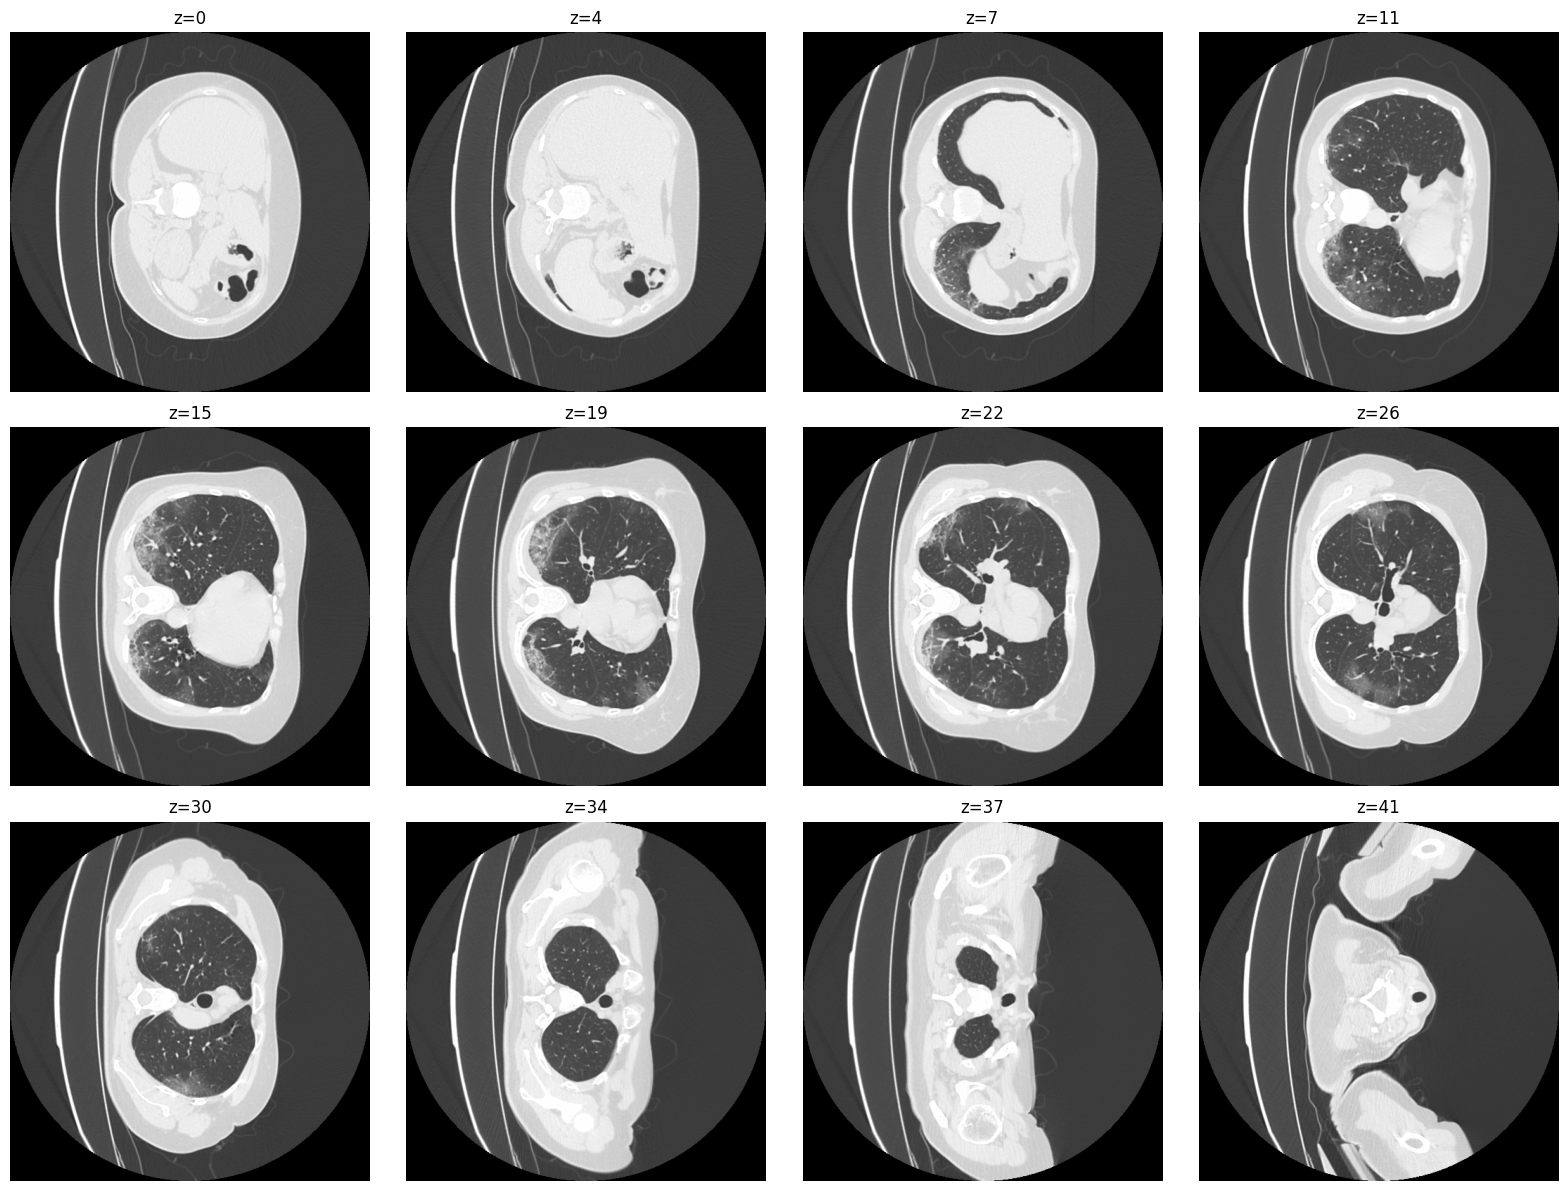

In [17]:
import os
import numpy as np
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt

# ==== ПУТЬ К ФАЙЛУ ====
FILE = "/kaggle/input/mosmeddata-chest-ct-scans-with-covid19/MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0/studies/CT-4/study_1110.nii"

# ==== ВАША ПРЕДОБРАБОТКА (без изменений) ====
def _apply_window(hu, center, width):
    """Клиппинг по окну + нормализация в [0,1]."""
    lo = center - width / 2.0
    hi = center + width / 2.0
    img = np.clip(hu, lo, hi)
    return (img - lo) / (hi - lo + 1e-6)

def select_step(n_slices: int) -> int:
    if n_slices < 50:   return 1
    elif n_slices < 100:return 2
    elif n_slices < 200:return 4
    elif n_slices < 400:return 6
    else:               return 8

def load_slices_from_nii(path: str):
    """
    Загружаем .nii, берём срезы по правилу выбора шага,
    применяем Lung window (C=-600, W=1500),
    возвращаем список PIL.Image (L) + количество срезов + количество выбранных + индексы.
    """
    nii = nib.load(path)
    arr = nii.get_fdata()
    n_slices = arr.shape[2]  # третья ось = глубина
    step = select_step(n_slices)

    indices = list(range(0, n_slices, step))
    images = []
    for i in indices:
        slice_2d = arr[:, :, i]
        lung_img = _apply_window(slice_2d, center=-600, width=1500)
        u8 = (lung_img * 255.0).astype(np.uint8)
        images.append(Image.fromarray(u8, mode="L"))

    return images, n_slices, len(indices), indices

# ==== ЗАГРУЗКА И ВИЗУАЛИЗАЦИЯ ====
images, n_slices, n_used, indices = load_slices_from_nii(FILE)
print(f"Total slices in volume: {n_slices} | Used: {n_used} | Step: {select_step(n_slices)}")

# Покажем до 12 равномерно распределённых срезов из подготовленного списка
k = min(12, len(images))
if k == 0:
    raise RuntimeError("Нет срезов для отображения.")
show_idxs = np.linspace(0, len(images)-1, k).round().astype(int)

cols = 4
rows = int(np.ceil(k / cols))
plt.figure(figsize=(4*cols, 4*rows))
for j, idx in enumerate(show_idxs, 1):
    plt.subplot(rows, cols, j)
    # PIL.Image в L → matplotlib сам отрисует в сером; фиксируем серую палитру
    plt.imshow(images[idx], cmap="gray", vmin=0, vmax=255)
    plt.title(f"z={indices[idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


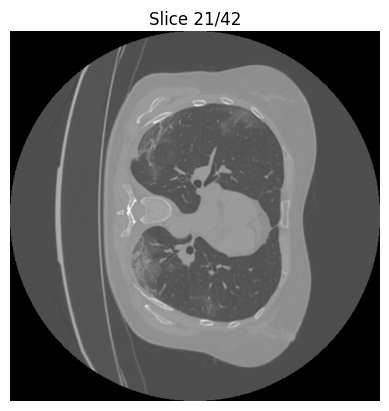

Shape: (512, 512, 42)


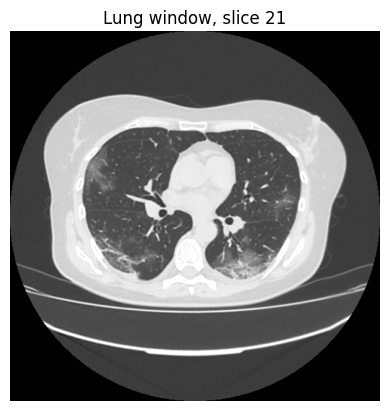

In [18]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_one_slice_nii(path: str, slice_index: int = None):
    """
    Загрузить nii, выбрать 1 срез и показать его (min-max нормализация).
    """
    nii = nib.load(path)
    arr = nii.get_fdata()
    n_slices = arr.shape[2]

    # если индекс не задан → берём центральный
    if slice_index is None:
        slice_index = n_slices // 2

    slice_2d = arr[:, :, slice_index]

    # нормализация в [0,1]
    slice_norm = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min() + 1e-6)

    # в [0..255] для PIL
    u8 = (slice_norm * 255).astype(np.uint8)
    img = Image.fromarray(u8, mode="L")

    # визуализация
    plt.imshow(img, cmap="gray")
    plt.title(f"Slice {slice_index}/{n_slices}")
    plt.axis("off")
    plt.show()

    return img

# пример вызова:
img = show_one_slice_nii("/kaggle/input/mosmeddata-chest-ct-scans-with-covid19/MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0/studies/CT-4/study_1110.nii", slice_index=21)


import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def _apply_window(hu, center, width):
    """Клиппинг по окну + нормализация в [0,1]."""
    lo = center - width / 2.0
    hi = center + width / 2.0
    img = np.clip(hu, lo, hi)
    return (img - lo) / (hi - lo + 1e-6)

# путь к вашему файлу
nii_path = "/kaggle/input/mosmeddata-chest-ct-scans-with-covid19/MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0/studies/CT-4/study_1110.nii"

# загрузка NIfTI
nii = nib.load(nii_path)
arr = nii.get_fdata()

print("Shape:", arr.shape)

# берём центральный срез (ось Z = 2)
z = arr.shape[2] // 2
slice_2d = arr[:, :, z]

# применяем Lung window
lung_img = _apply_window(slice_2d, center=-600, width=1500)

# визуализация
plt.imshow(lung_img.T, cmap="gray", origin="lower", vmin=0, vmax=1)
plt.title(f"Lung window, slice {z}")
plt.axis("off")
plt.show()


# KT lung cancer

In [5]:
df_cancer = pd.read_excel('/kaggle/input/mosmeddata-ldct-lungcr-type-i-v-1/MosMedData-LDCT-LUNGCR-type I-v 1/dataset_registry.xlsx', sheet_name='Sheet1')
df_cancer.head()

Unnamed: 0                                study_instance_anon  pathology
0           0  1.2.643.5.1.13.13.12.2.77.8252.140209120714130...          1
1           1  1.2.643.5.1.13.13.12.2.77.8252.010201090513021...          0
2           2  1.2.643.5.1.13.13.12.2.77.8252.000208011208051...          0
3           3  1.2.643.5.1.13.13.12.2.77.8252.021212080000070...          1
4           4  1.2.643.5.1.13.13.12.2.77.8252.011307020410010...          0

In [6]:
df_cancer.shape

(100, 3)

In [7]:
df_cancer.study_instance_anon.values[0]

'1.2.643.5.1.13.13.12.2.77.8252.14020912071413071311010704150801'

In [8]:
id_to_check = '1.2.643.5.1.13.13.12.2.77.8252.00001007020103130905041401130706'
df_cancer[df_cancer.study_instance_anon == id_to_check]

Unnamed: 0                                study_instance_anon  pathology
98          98  1.2.643.5.1.13.13.12.2.77.8252.000010070201031...          1

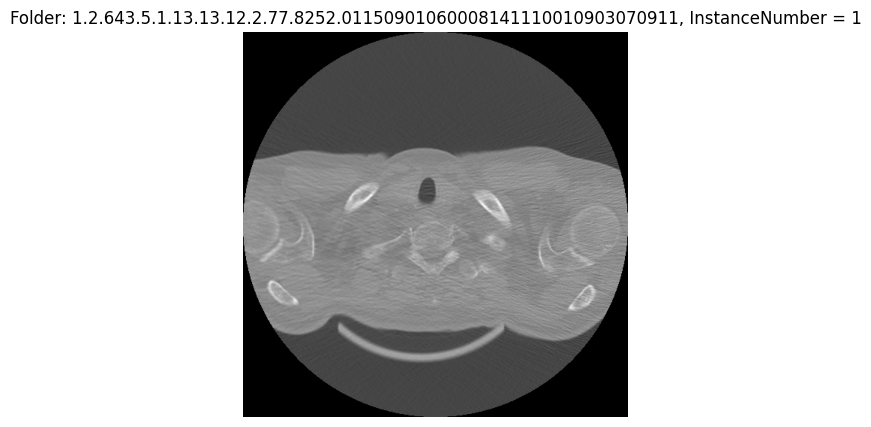

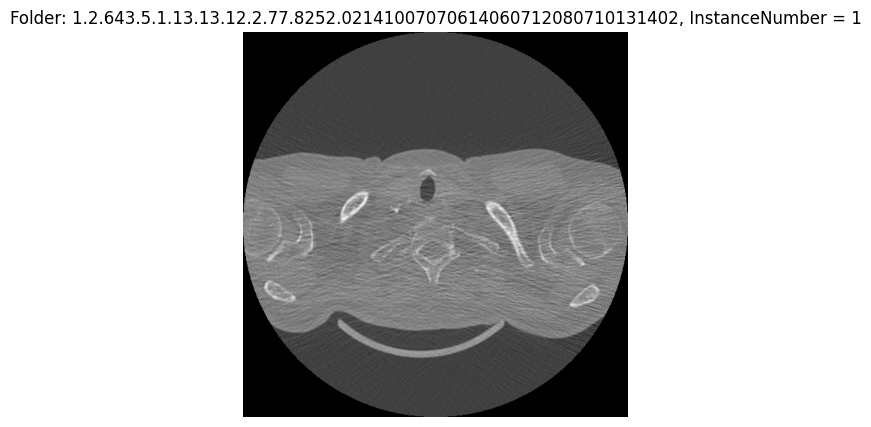

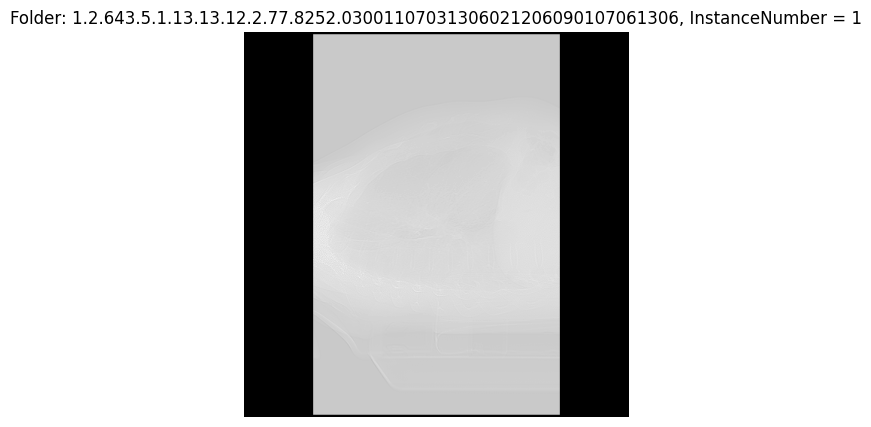

Всего файлов: 664
Максимальный InstanceNumber: 601
len == max?: False


In [9]:
import os
import pydicom

# путь к корневой директории
ROOT = "/kaggle/input/mosmeddata-ldct-lungcr-type-i-v-1/MosMedData-LDCT-LUNGCR-type I-v 1/studies/1.2.643.5.1.13.13.12.2.77.8252.00141105120908001315070013000908"

import os
import pydicom
import matplotlib.pyplot as plt

instance_numbers = []

for sub in sorted(os.listdir(ROOT)):
    sub_path = os.path.join(ROOT, sub)
    if not os.path.isdir(sub_path):
        continue

    for root, _, files in os.walk(sub_path):
        for fname in files:
            fpath = os.path.join(root, fname)
            try:
                ds = pydicom.dcmread(fpath, force=True)
                val = ds.get("InstanceNumber", None)
                if val is not None:
                    val = int(val)
                    instance_numbers.append(val)

                    # визуализация, если InstanceNumber == 1
                    if val == 2 and hasattr(ds, "pixel_array"):
                        arr = ds.pixel_array
                        plt.figure(figsize=(5, 5))
                        plt.imshow(arr, cmap="gray")
                        plt.title(f"Folder: {sub}, InstanceNumber = 1")
                        plt.axis("off")
                        plt.show()
            except Exception:
                continue

if instance_numbers:
    length = len(instance_numbers)
    max_val = max(instance_numbers)
    print("Всего файлов:", length)
    print("Максимальный InstanceNumber:", max_val)
    print("len == max?:", length == max_val)
else:
    print("❌ InstanceNumber не найден.")



In [10]:
import os
import numpy as np
import pandas as pd
import pydicom
from PIL import Image
from tqdm import tqdm

# ====== Настройки и входные данные ======
# df_cancer: должен содержать столбцы 'study_instance_anon' (имя папки исследования) и 'pathology' (1/0)
# cancer_root: путь к корневой папке с исследованиями
# pipe: ваша модель (как раньше), prompt: ваш промпт (как раньше)

# Пример:
cancer_root = "/kaggle/input/mosmeddata-ldct-lungcr-type-i-v-1/MosMedData-LDCT-LUNGCR-type I-v 1/studies"
df_cancer= pd.read_excel('/kaggle/input/mosmeddata-ldct-lungcr-type-i-v-1/MosMedData-LDCT-LUNGCR-type I-v 1/dataset_registry.xlsx', sheet_name='Sheet1')


# ====== Вспомогательные функции ======
def _to_hu(ds):
    """DICOM -> HU с учётом RescaleSlope/Intercept."""
    arr = ds.pixel_array.astype(np.float32)
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    inter = float(getattr(ds, "RescaleIntercept", 0.0))
    hu = arr * slope + inter
    # инвертируем для MONOCHROME1
    if str(getattr(ds, "PhotometricInterpretation", "")).upper() == "MONOCHROME1":
        hu = -hu
    return hu

def _apply_window(hu, center, width):
    """Клиппинг по окну + нормализация в [0,1]."""
    lo = center - width / 2.0
    hi = center + width / 2.0
    img = np.clip(hu, lo, hi)
    return (img - lo) / (hi - lo + 1e-6)

def select_step(n_slices: int) -> int:
    """Выбор базового шага n по числу срезов."""
    if n_slices < 50:   return 1
    if n_slices < 100:  return 2
    if n_slices < 200:  return 4
    if n_slices < 400:  return 6
    if n_slices < 600:  return 8
    return 10

def quartile_sample_indices(n_files: int, n: int):
    """Q1/Q4 шаг n; Q2/Q3 шаг n//2 (без лишних проверок)."""
    q1 = n_files // 4
    q2 = n_files // 2
    q3 = (3 * n_files) // 4
    idx = []
    idx += list(range(0,   q1, n))        # Q1
    idx += list(range(q1,  q2, n//2))     # Q2
    idx += list(range(q2,  q3, n//2))     # Q3
    idx += list(range(q3, n_files, n))    # Q4
    return idx

def list_dicom_files(folder):
    """Собрать пути к DICOM-файлам (простая фильтрация по расширению/всем файлам)."""
    files = []
    for f in os.listdir(folder):
        path = os.path.join(folder, f)
        if os.path.isfile(path):
            # допускаем любые имена; если нужно — ограничить по .dcm
            files.append(path)
    return files

def choose_deepest_folder_with_max_files(study_root):
    """
    Если в папке исследования несколько подпапок — выбрать ту,
    где максимум файлов (по числу файлов внутри).
    Если подпапок нет — вернуть сам study_root.
    """
    subdirs = [os.path.join(study_root, d) for d in os.listdir(study_root)
               if os.path.isdir(os.path.join(study_root, d))]
    if not subdirs:
        return study_root
    # считаем файлов в каждой подпапке (не уходим глубже)
    counts = [(sd, len(list_dicom_files(sd))) for sd in subdirs]
    # если подпапки тоже содержат подпапки со срезами — можно углубиться ещё на уровень:
    # counts = []
    # for sd in subdirs:
    #     inner_subdirs = [os.path.join(sd, d) for d in os.listdir(sd)
    #                      if os.path.isdir(os.path.join(sd, d))]
    #     if inner_subdirs:
    #         # выбирать из внутренних
    #         inner_counts = [(isd, len(list_dicom_files(isd))) for isd in inner_subdirs]
    #         best_inner = max(inner_counts, key=lambda x: x[1])[0]
    #         counts.append((best_inner, len(list_dicom_files(best_inner))))
    #     else:
    #         counts.append((sd, len(list_dicom_files(sd))))
    best = max(counts, key=lambda x: x[1])[0]
    return best

def load_dicom_series_sorted_by_instance(folder):
    """
    Прочитать ВСЕ DICOM из папки, отсортированные по InstanceNumber.
    Вернуть список (ds_list) в корректном порядке.
    """
    paths = list_dicom_files(folder)
    items = []
    for p in paths:
        try:
            ds = pydicom.dcmread(p, stop_before_pixels=False)
            inst = int(getattr(ds, "InstanceNumber", 1_000_000))  # если нет, уйдёт в конец
            items.append((inst, p))
        except Exception:
            # пропускаем не-DICOM/битые файлы
            continue
    items.sort(key=lambda x: x[0])
    ds_list = []
    for _, p in items:
        try:
            ds = pydicom.dcmread(p, stop_before_pixels=False)
            ds_list.append(ds)
        except Exception:
            pass
    return ds_list

def dicom_series_to_images_lung(ds_list, indices):
    """
    Взять указанные индексы из отсортированного списка DICOM, применить Lung window,
    вернуть список PIL.Image.
    """
    images = []
    for i in indices:
        ds = ds_list[i]
        hu = _to_hu(ds)
        img01 = _apply_window(hu, center=-600, width=1500)  # Lung
        u8 = (img01 * 255.0).astype(np.uint8)
        images.append(Image.fromarray(u8, mode="L"))
    return images

def classify_images(images, pipe, prompt):
    """Классификация списка PIL.Image вашей моделью."""
    counts = {"normal": 0, "anomaly": 0}
    for image in images:
        messages_test = [
            {
                "role": "system",
                "content": [{"type": "text", "text": "You are an expert radiologist."}]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "image": image},
                ]
            }
        ]
        out = pipe(text=messages_test, max_new_tokens=256)
        text = out[0]["generated_text"][-1]["content"]
        try:
            label = text.split(":")[1].split("\n")[0].strip().lower()
            if label in counts:
                counts[label] += 1
        except Exception:
            # если ответ в другом формате — просто пропускаем
            pass
    return counts

Найдена внешняя папка: /kaggle/input/mosmeddata-ldct-lungcr-type-i-v-1/MosMedData-LDCT-LUNGCR-type I-v 1/studies/1.2.643.5.1.13.13.12.2.77.8252.05090107140106080407100314040704
Найдена внутренняя папка: /kaggle/input/mosmeddata-ldct-lungcr-type-i-v-1/MosMedData-LDCT-LUNGCR-type I-v 1/studies/1.2.643.5.1.13.13.12.2.77.8252.05090107140106080407100314040704/1.2.643.5.1.13.13.12.2.77.8252.12140500150415020910141405000408


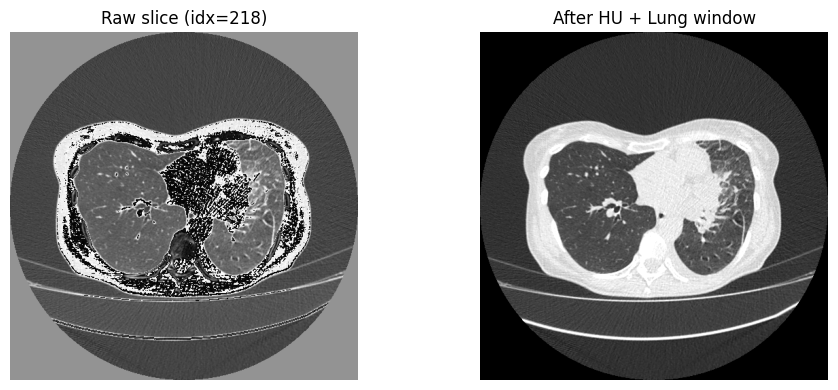

In [13]:
import os
import matplotlib.pyplot as plt

# --- Подстроки для поиска ---
outer_substr = "1.2.643.5.1.13.13.12.2.77.8252.050901071401060"
inner_substr = "1.2.643.5.1.13.13.12.2.77.8252.121405001504150"

# --- 1) ищем внешнюю папку внутри cancer_root ---
outer_folder = None
for name in os.listdir(cancer_root):
    if outer_substr in name:
        outer_folder = os.path.join(cancer_root, name)
        break

if outer_folder is None:
    raise FileNotFoundError(f"Не найдена папка с подстрокой {outer_substr}")
print("Найдена внешняя папка:", outer_folder)

# --- 2) ищем внутреннюю папку ---
inner_folder = None
for name in os.listdir(outer_folder):
    if inner_substr in name:
        inner_folder = os.path.join(outer_folder, name)
        break

if inner_folder is None:
    raise FileNotFoundError(f"Не найдена внутренняя папка с подстрокой {inner_substr}")
print("Найдена внутренняя папка:", inner_folder)

# --- 3) читаем серию DICOM ---
ds_list = load_dicom_series_sorted_by_instance(inner_folder)
assert len(ds_list) > 0, "Не удалось прочитать ни одного DICOM-файла"

mid_idx = len(ds_list) // 2
ds_mid = ds_list[mid_idx]

# --- 4) готовим изображения до / после ---
raw = ds_mid.pixel_array
hu = _to_hu(ds_mid)
lung = _apply_window(hu, center=-600, width=1500)

raw_u8 = (raw.astype("float32") / max(raw.max(), 1) * 255).astype("uint8")
lung_u8 = (lung * 255).astype("uint8")

# --- 5) визуализация ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(raw_u8, cmap="gray")
plt.title(f"Raw slice (idx={mid_idx})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(lung_u8, cmap="gray")
plt.title("After HU + Lung window")
plt.axis("off")
plt.tight_layout()
plt.show()


In [26]:


# ====== Подготовка выборки: 25 патологий и 25 норм ======
# Берём "первые" по датафрейму, как просили
df_pos = df_cancer[df_cancer["pathology"] == 1].head(25).copy()
df_neg = df_cancer[df_cancer["pathology"] == 0].head(25).copy()
df_take = pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True)

# ====== Основной цикл ======
results = []

prompt = """
Task: classify chest CT scan for pulmonary abnormalities.
Steps:
1) Examine both lungs for opacities, consolidations, ground-glass changes, pleural effusion, pneumothorax, fibrosis, or nodules.
2) If no abnormalities are visible, output label: normal.
3) If any abnormality is suspected, output label: anomaly.
4) Output format:
   - label: normal OR label: anomaly
"""

for _, row in tqdm(df_take.iterrows(), total=len(df_take), desc="Processing studies"):
    study_id = str(row["study_instance_anon"])
    folder_study_root = os.path.join(cancer_root, study_id)

    if not os.path.isdir(folder_study_root):
        # если папки нет — пропускаем
        continue

    # 1) выбрать подпапку с наибольшим числом файлов
    series_folder = choose_deepest_folder_with_max_files(folder_study_root)

    # 2) прочитать DICOM-серию в порядке InstanceNumber
    ds_series = load_dicom_series_sorted_by_instance(series_folder)
    n_slices = len(ds_series)
    if n_slices == 0:
        continue

    # 3) выбрать индексы срезов по квартилям на основе шага n
    n = select_step(n_slices)
    indices = quartile_sample_indices(n_slices, n)

    # 4) собрать изображения (Lung window) для выбранных индексов
    images = dicom_series_to_images_lung(ds_series, indices)

    # 5) классификация
    counts = classify_images(images, pipe, prompt)

    # 6) запись результата
    results.append({
        "study_id": study_id,
        "folder": os.path.basename(series_folder),  # можно заменить на метку класса, если нужна иная "folder"
        "n_slices": n_slices,
        "n_used": len(indices),
        "count_normal": counts["normal"],
        "count_anomaly": counts["anomaly"],
        "pathology": int(row["pathology"]),
    })

# ====== Итоговая таблица ======
df_results = pd.DataFrame(results)
df_results["anomaly_share"] = df_results["count_anomaly"] / (df_results["count_anomaly"] + df_results["count_normal"])

display(df_results)

# Средняя доля аномалий по "folder" (имя выбранной подпапки серии)
print("\nMean anomaly_share by folder:")
display(df_results.groupby(by="pathology")["anomaly_share"].mean())


Processing studies: 100%|██████████| 50/50 [3:08:55<00:00, 226.71s/it]  


study_id  \
0   1.2.643.5.1.13.13.12.2.77.8252.140209120714130...   
1   1.2.643.5.1.13.13.12.2.77.8252.021212080000070...   
2   1.2.643.5.1.13.13.12.2.77.8252.011107060012040...   
3   1.2.643.5.1.13.13.12.2.77.8252.030515151115051...   
4   1.2.643.5.1.13.13.12.2.77.8252.121212000103121...   
5   1.2.643.5.1.13.13.12.2.77.8252.040215051210080...   
6   1.2.643.5.1.13.13.12.2.77.8252.140512150011050...   
7   1.2.643.5.1.13.13.12.2.77.8252.060311041510101...   
8   1.2.643.5.1.13.13.12.2.77.8252.020405121409040...   
9   1.2.643.5.1.13.13.12.2.77.8252.020000151412070...   
10  1.2.643.5.1.13.13.12.2.77.8252.150009141008050...   
11  1.2.643.5.1.13.13.12.2.77.8252.021009010602141...   
12  1.2.643.5.1.13.13.12.2.77.8252.000707071109051...   
13  1.2.643.5.1.13.13.12.2.77.8252.041010061111120...   
14  1.2.643.5.1.13.13.12.2.77.8252.070302000101110...   
15  1.2.643.5.1.13.13.12.2.77.8252.030213001412111...   
16  1.2.643.5.1.13.13.12.2.77.8252.090912141100060...   
17  1.2.643.5.1.13.13.12.2.77.8252.021110070007040...   
18  1.2.643.5.1.13.13.12.2.77.8252.050901071401060...   
19  1.2.643.5.1.13.13.12.2.77.8252.041006050308131...   
20  1.2.643.5.1.13.13.12.2.77.8252.050203131210150...   
21  1.2.643.5.1.13.13.12.2.77.8252.081101130402050...   
22  1.2.643.5.1.13.13.12.2.77.8252.140807000604080...   
23  1.2.643.5.1.13.13.12.2.77.8252.100515100812100...   
24  1.2.643.5.1.13.13.12.2.77.8252.100304030214151...   
25  1.2.643.5.1.13.13.12.2.77.8252.010201090513021...   
26  1.2.643.5.1.13.13.12.2.77.8252.000208011208051...   
27  1.2.643.5.1.13.13.12.2.77.8252.011307020410010...   
28  1.2.643.5.1.13.13.12.2.77.8252.070700040205141...   
29  1.2.643.5.1.13.13.12.2.77.8252.011407030115131...   
30  1.2.643.5.1.13.13.12.2.77.8252.130403031210110...   
31  1.2.643.5.1.13.13.12.2.77.8252.060215061010031...   
32  1.2.643.5.1.13.13.12.2.77.8252.000701141311130...   
33  1.2.643.5.1.13.13.12.2.77.8252.070801060308090...   
34  1.2.643.5.1.13.13.12.2.77.8252.090712000700001...   
35  1.2.643.5.1.13.13.12.2.77.8252.020013010109010...   
36  1.2.643.5.1.13.13.12.2.77.8252.061202010206111...   
37  1.2.643.5.1.13.13.12.2.77.8252.050809111413141...   
38  1.2.643.5.1.13.13.12.2.77.8252.120212150710000...   
39  1.2.643.5.1.13.13.12.2.77.8252.040012091014070...   
40  1.2.643.5.1.13.13.12.2.77.8252.080207070304120...   
41  1.2.643.5.1.13.13.12.2.77.8252.080313110415150...   
42  1.2.643.5.1.13.13.12.2.77.8252.130100120803151...   
43  1.2.643.5.1.13.13.12.2.77.8252.110313031404100...   
44  1.2.643.5.1.13.13.12.2.77.8252.131011011005021...   
45  1.2.643.5.1.13.13.12.2.77.8252.130604111313060...   
46  1.2.643.5.1.13.13.12.2.77.8252.110915000908131...   
47  1.2.643.5.1.13.13.12.2.77.8252.050615030901000...   
48  1.2.643.5.1.13.13.12.2.77.8252.131306010210010...   
49  1.2.643.5.1.13.13.12.2.77.8252.011315131005021...   

                                               folder  n_slices  n_used  \
0   1.2.643.5.1.13.13.12.2.77.8252.010915090101080...       388     100   
1   1.2.643.5.1.13.13.12.2.77.8252.080902151111090...       651     100   
2   1.2.643.5.1.13.13.12.2.77.8252.070203100513060...       419      81   
3   1.2.643.5.1.13.13.12.2.77.8252.141107040514130...       482      92   
4   1.2.643.5.1.13.13.12.2.77.8252.100612100406080...       438      84   
5   1.2.643.5.1.13.13.12.2.77.8252.031206030204121...       521     100   
6   1.2.643.5.1.13.13.12.2.77.8252.031210130208000...       426      82   
7   1.2.643.5.1.13.13.12.2.77.8252.071511110303060...       721     109   
8   1.2.643.5.1.13.13.12.2.77.8252.051013090408151...       671     102   
9   1.2.643.5.1.13.13.12.2.77.8252.090415151408051...       394     100   
10  1.2.643.5.1.13.13.12.2.77.8252.000307091401081...       482      92   
11  1.2.643.5.1.13.13.12.2.77.8252.110509080214080...       401      76   
12  1.2.643.5.1.13.13.12.2.77.8252.080410010912021...       701     106   
13  1.2.643.5.1.13.13.12.2.77.8252.111210100810121...        71      54   
14  1.2.643.


Mean anomaly_share by folder:


pathology
0    0.107522
1    0.183562
Name: anomaly_share, dtype: float64

In [27]:
from sklearn.metrics import precision_recall_fscore_support

print(roc_auc_score(df_results.pathology, df_results.anomaly_share))
y_true = df_results["pathology"].values
y_score = df_results["anomaly_share"].values

best_f1, best_thr, best_prec, best_rec = 0, None, None, None

for thr in np.linspace(0, 1, 101):  # перебор порогов от 0 до 1
    y_pred = (y_score >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr, best_prec, best_rec = f1, thr, prec, rec

print(f"Best threshold: {best_thr:.2f}")
print(f"Precision: {best_prec:.3f}, Recall: {best_rec:.3f}, F1: {best_f1:.3f}")


0.7295999999999999
Best threshold: 0.09
Precision: 0.618, Recall: 0.840, F1: 0.712


In [28]:
from sklearn.metrics import precision_recall_fscore_support

y_true = df_results["pathology"].values
y_score = df_results["anomaly_share"].values

beta = 2.25  # recall в 4 раза важнее precision

best_fbeta, best_thr, best_prec, best_rec = 0, None, None, None

for thr in np.linspace(0, 1, 101):
    y_pred = (y_score >= thr).astype(int)
    prec, rec, _, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    fbeta = (1 + beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-12)
    if fbeta > best_fbeta:
        best_fbeta, best_thr, best_prec, best_rec = fbeta, thr, prec, rec

print(f"Best threshold (F{beta}): {best_thr:.2f}")
print(f"Precision: {best_prec:.3f}, Recall: {best_rec:.3f}, F{beta}: {best_fbeta:.3f}")


Best threshold (F2.25): 0.03
Precision: 0.532, Recall: 1.000, F2.25: 0.873


In [29]:
df_results_10 = df_results.copy()

In [33]:
# import os
# import numpy as np
# import pandas as pd
# import pydicom
# from PIL import Image
# from tqdm import tqdm

# # ====== Настройки и входные данные ======
# # df_cancer: должен содержать столбцы 'study_instance_anon' (имя папки исследования) и 'pathology' (1/0)
# # cancer_root: путь к корневой папке с исследованиями
# # pipe: ваша модель (как раньше), prompt: ваш промпт (как раньше)

# # Пример:
# cancer_root = "/kaggle/input/mosmeddata-ldct-lungcr-type-i-v-1/MosMedData-LDCT-LUNGCR-type I-v 1/studies"
# df_cancer= pd.read_excel('/kaggle/input/mosmeddata-ldct-lungcr-type-i-v-1/MosMedData-LDCT-LUNGCR-type I-v 1/dataset_registry.xlsx', sheet_name='Sheet1')


# # ====== Вспомогательные функции ======
# def _to_hu(ds):
#     """DICOM -> HU с учётом RescaleSlope/Intercept."""
#     arr = ds.pixel_array.astype(np.float32)
#     slope = float(getattr(ds, "RescaleSlope", 1.0))
#     inter = float(getattr(ds, "RescaleIntercept", 0.0))
#     hu = arr * slope + inter
#     # инвертируем для MONOCHROME1
#     if str(getattr(ds, "PhotometricInterpretation", "")).upper() == "MONOCHROME1":
#         hu = -hu
#     return hu

# def _apply_window(hu, center, width):
#     """Клиппинг по окну + нормализация в [0,1]."""
#     lo = center - width / 2.0
#     hi = center + width / 2.0
#     img = np.clip(hu, lo, hi)
#     return (img - lo) / (hi - lo + 1e-6)

# def select_step(n_slices: int) -> int:
#     """Выбор базового шага n по числу срезов."""
#     if n_slices < 50:   return 1
#     if n_slices < 100:  return 2
#     if n_slices < 200:  return 4
#     if n_slices < 400:  return 6
#     if n_slices < 600:  return 8
#     return 10

# def quartile_sample_indices(n_files: int, n: int):
#     """Q1/Q4 шаг n; Q2/Q3 шаг n//2 (без лишних проверок)."""
#     q1 = n_files // 4
#     q2 = n_files // 2
#     q3 = (3 * n_files) // 4
#     idx = []
#     idx += list(range(0,   q1, n))        # Q1
#     idx += list(range(q1,  q2, n//2))     # Q2
#     idx += list(range(q2,  q3, n//2))     # Q3
#     idx += list(range(q3, n_files, n))    # Q4
#     return idx

# def list_dicom_files(folder):
#     """Собрать пути к DICOM-файлам (простая фильтрация по расширению/всем файлам)."""
#     files = []
#     for f in os.listdir(folder):
#         path = os.path.join(folder, f)
#         if os.path.isfile(path):
#             # допускаем любые имена; если нужно — ограничить по .dcm
#             files.append(path)
#     return files

# def choose_deepest_folder_with_max_files(study_root):
#     """
#     Если в папке исследования несколько подпапок — выбрать ту,
#     где максимум файлов (по числу файлов внутри).
#     Если подпапок нет — вернуть сам study_root.
#     """
#     subdirs = [os.path.join(study_root, d) for d in os.listdir(study_root)
#                if os.path.isdir(os.path.join(study_root, d))]
#     if not subdirs:
#         return study_root
#     # считаем файлов в каждой подпапке (не уходим глубже)
#     counts = [(sd, len(list_dicom_files(sd))) for sd in subdirs]
#     # если подпапки тоже содержат подпапки со срезами — можно углубиться ещё на уровень:
#     # counts = []
#     # for sd in subdirs:
#     #     inner_subdirs = [os.path.join(sd, d) for d in os.listdir(sd)
#     #                      if os.path.isdir(os.path.join(sd, d))]
#     #     if inner_subdirs:
#     #         # выбирать из внутренних
#     #         inner_counts = [(isd, len(list_dicom_files(isd))) for isd in inner_subdirs]
#     #         best_inner = max(inner_counts, key=lambda x: x[1])[0]
#     #         counts.append((best_inner, len(list_dicom_files(best_inner))))
#     #     else:
#     #         counts.append((sd, len(list_dicom_files(sd))))
#     best = max(counts, key=lambda x: x[1])[0]
#     return best

# def load_dicom_series_sorted_by_instance(folder):
#     """
#     Прочитать ВСЕ DICOM из папки, отсортированные по InstanceNumber.
#     Вернуть список (ds_list) в корректном порядке.
#     """
#     paths = list_dicom_files(folder)
#     items = []
#     for p in paths:
#         try:
#             ds = pydicom.dcmread(p, stop_before_pixels=False)
#             inst = int(getattr(ds, "InstanceNumber", 1_000_000))  # если нет, уйдёт в конец
#             items.append((inst, p))
#         except Exception:
#             # пропускаем не-DICOM/битые файлы
#             continue
#     items.sort(key=lambda x: x[0])
#     ds_list = []
#     for _, p in items:
#         try:
#             ds = pydicom.dcmread(p, stop_before_pixels=False)
#             ds_list.append(ds)
#         except Exception:
#             pass
#     return ds_list

# def dicom_series_to_images_lung(ds_list, indices):
#     """
#     Взять указанные индексы из отсортированного списка DICOM, применить Lung window,
#     вернуть список PIL.Image.
#     """
#     images = []
#     for i in indices:
#         ds = ds_list[i]
#         hu = _to_hu(ds)
#         img01 = _apply_window(hu, center=-600, width=1500)  # Lung
#         u8 = (img01 * 255.0).astype(np.uint8)
#         images.append(Image.fromarray(u8, mode="L"))
#     return images

# def classify_images(images, pipe, prompt):
#     """Классификация списка PIL.Image вашей моделью."""
#     counts = {"normal": 0, "anomaly": 0}
#     for image in images:
#         messages_test = [
#             {
#                 "role": "system",
#                 "content": [{"type": "text", "text": "You are an expert radiologist."}]
#             },
#             {
#                 "role": "user",
#                 "content": [
#                     {"type": "text", "text": prompt},
#                     {"type": "image", "image": image},
#                 ]
#             }
#         ]
#         out = pipe(text=messages_test, max_new_tokens=256)
#         text = out[0]["generated_text"][-1]["content"]
#         try:
#             label = text.split(":")[1].split("\n")[0].strip().lower()
#             if label in counts:
#                 counts[label] += 1
#         except Exception:
#             # если ответ в другом формате — просто пропускаем
#             pass
#     return counts

# # ====== Подготовка выборки: 10 патологий и 10 норм ======
# # Берём "первые" по датафрейму, как просили
# df_pos = df_cancer[df_cancer["pathology"] == 1].tail(10).copy()
# df_neg = df_cancer[df_cancer["pathology"] == 0].tail(10).copy()
# df_take = pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True)

# # ====== Основной цикл ======
# results = []

# ## Old prompt
# # prompt = """
# # Task: classify chest CT scan for pulmonary abnormalities.
# # Steps:
# # 1) Examine both lungs for opacities, consolidations, ground-glass changes, pleural effusion, pneumothorax, fibrosis, or nodules.
# # 2) If no abnormalities are visible, output label: normal.
# # 3) If any abnormality is suspected, output label: anomaly.
# # 4) Output format:
# #    - label: normal OR label: anomaly
# # """

# # New Prompt
# prompt = """
# Task: classify chest CT scan for lung cancer.
# Steps:
# 1) Carefully examine both lungs for suspicious nodules, masses, or irregular opacities that may indicate malignancy.
# 2) Evaluate size, shape, margins, and density of any detected lesion; note spiculated or irregular contours, and growth beyond normal tissue patterns.
# 3) If no suspicious lesion is visible, output label: normal.
# 4) If any suspicious lesion suggestive of cancer is found, output label: anomaly.
# 5) Output format:
#    - label: normal OR label: anomaly
# """


# for _, row in tqdm(df_take.iterrows(), total=len(df_take), desc="Processing studies"):
#     study_id = str(row["study_instance_anon"])
#     folder_study_root = os.path.join(cancer_root, study_id)

#     if not os.path.isdir(folder_study_root):
#         # если папки нет — пропускаем
#         continue

#     # 1) выбрать подпапку с наибольшим числом файлов
#     series_folder = choose_deepest_folder_with_max_files(folder_study_root)

#     # 2) прочитать DICOM-серию в порядке InstanceNumber
#     ds_series = load_dicom_series_sorted_by_instance(series_folder)
#     n_slices = len(ds_series)
#     if n_slices == 0:
#         continue

#     # 3) выбрать индексы срезов по квартилям на основе шага n
#     n = select_step(n_slices)
#     indices = quartile_sample_indices(n_slices, n)

#     # 4) собрать изображения (Lung window) для выбранных индексов
#     images = dicom_series_to_images_lung(ds_series, indices)

#     # 5) классификация
#     counts = classify_images(images, pipe, prompt)

#     # 6) запись результата
#     results.append({
#         "study_id": study_id,
#         "folder": os.path.basename(series_folder),  # можно заменить на метку класса, если нужна иная "folder"
#         "n_slices": n_slices,
#         "n_used": len(indices),
#         "count_normal": counts["normal"],
#         "count_anomaly": counts["anomaly"],
#         "pathology": int(row["pathology"]),
#     })

# # ====== Итоговая таблица ======
# df_results = pd.DataFrame(results)
# df_results["anomaly_share"] = df_results["count_anomaly"] / (df_results["count_anomaly"] + df_results["count_normal"])

# display(df_results)

# # Средняя доля аномалий по "folder" (имя выбранной подпапки серии)
# print("\nMean anomaly_share by folder:")
# display(df_results.groupby(by="pathology")["anomaly_share"].mean())


In [34]:
# print(print(roc_auc_score(df_results.pathology, df_results.anomaly_share)))
# from sklearn.metrics import precision_recall_fscore_support

# y_true = df_results["pathology"].values
# y_score = df_results["anomaly_share"].values

# best_f1, best_thr, best_prec, best_rec = 0, None, None, None

# for thr in np.linspace(0, 1, 101):  # перебор порогов от 0 до 1
#     y_pred = (y_score >= thr).astype(int)
#     prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
#     if f1 > best_f1:
#         best_f1, best_thr, best_prec, best_rec = f1, thr, prec, rec

# print(f"Best threshold: {best_thr:.2f}")
# print(f"Precision: {best_prec:.3f}, Recall: {best_rec:.3f}, F1: {best_f1:.3f}")


In [35]:
# df_results_20 = df_results.copy()

In [31]:
df_results = pd.concat([df_results_20, df_results_10], axis=0, ignore_index=True)
print(print(roc_auc_score(df_results.pathology, df_results.anomaly_share)))

0.7295999999999999
None


# Rg X-ray Lung Diseases Images 

In [37]:
!ls /kaggle/input/x-ray-lung-diseases-images-9-classes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'00 Anatomia Normal'
'01 Processos Inflamatórios Pulmonares (Pneumonia)'
'02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)'
'03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)'
'04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)'
'05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)'
'06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)'
'07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)'
'08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)'


In [38]:
import re
import numpy as np
import pandas as pd
from PIL import Image
import torch
from pathlib import Path
from tqdm.auto import tqdm

# --- unchanged helper ---
def arr_to_pil(arr):
    if arr.ndim == 2:
        u8 = (np.clip(arr, 0, 1) * 255).astype(np.uint8)
        return Image.fromarray(u8, mode="L")
    elif arr.ndim == 3 and arr.shape[2] == 3:
        u8 = (np.clip(arr, 0, 1) * 255).astype(np.uint8)
        return Image.fromarray(u8, mode="RGB")
    else:
        raise ValueError(f"Unexpected array shape: {arr.shape}")

# --- NEW: robust pipe output text extractor ---
def extract_text_from_pipe_output(output_obj) -> str:
    """
    Try to normalize different output layouts from `pipe`.
    Returns a plain string best-effort concatenation of generated text.
    """
    try:
        item = output_obj[0] if isinstance(output_obj, (list, tuple)) else output_obj

        # Common layout: item["generated_text"] is either a dict or a list of messages
        if isinstance(item, dict) and "generated_text" in item:
            gen = item["generated_text"]
            if isinstance(gen, list):
                last_msg = gen[-1]
            else:
                last_msg = gen

            if isinstance(last_msg, dict):
                # Some pipes put content under "content" (list of blocks), others under "text"
                if "content" in last_msg:
                    content = last_msg["content"]
                    if isinstance(content, list):
                        parts = []
                        for c in content:
                            if isinstance(c, dict) and "text" in c:
                                parts.append(c["text"])
                            elif isinstance(c, str):
                                parts.append(c)
                        return "\n".join(parts).strip()
                    elif isinstance(content, str):
                        return content.strip()
                if "text" in last_msg:
                    return str(last_msg["text"]).strip()

            # Fallback stringify
            return str(last_msg)

        # Some pipelines return plain text under "text" at top level
        if isinstance(item, dict) and "text" in item:
            return str(item["text"]).strip()

        # Ultimate fallback
        return str(item).strip()

    except Exception:
        # If anything odd, just stringify
        return str(output_obj)

# --- NEW: safer parser always returning 2 fields ---
def parse_label_and_prob(text: str):
    """
    Returns (label:str|None, prob:float|None)
    - label ∈ {'normal','anomaly'} if present
    - prob clipped to [0,1] if a valid float is found
    """
    # label
    m_label = re.search(r'\blabel\s*:\s*(normal|anomaly)\b', text, flags=re.IGNORECASE)
    label = m_label.group(1).lower() if m_label else None

    # probability: grab the first 0..1 float (be tolerant to formats like 0.87, 1, 1.0)
    m_prob = re.search(r'\bprobability\b[^0-9\-]*([01](?:\.\d+)?|\.\d+)', text, flags=re.IGNORECASE)
    prob = None
    if m_prob:
        try:
            prob = float(m_prob.group(1))
            prob = float(np.clip(prob, 0.0, 1.0))
        except Exception:
            prob = None

    return label, prob  # ALWAYS exactly two values

# ===================== MAIN LOOP (kept same except for extraction/parsing) =====================
ROOT = Path("/kaggle/input/x-ray-lung-diseases-images-9-classes")
CLASS_DIRS = [
    "00 Anatomia Normal",
    "01 Processos Inflamatórios Pulmonares (Pneumonia)",
    "02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)",
    "03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)",
    "04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)",
    "05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)",
    "06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)",
    "07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)",
    "08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)",
]
N_PER_CLASS = 50

rows = []
first_error_text_sample = None  # capture first raw out_text if parsing fails

for class_name in CLASS_DIRS:
    class_path = ROOT / class_name
    if not class_path.exists():
        print(f"⚠️ Missing folder: {class_path}")
        continue

    image_paths = sorted([p for p in class_path.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png"}])[:N_PER_CLASS]
    if not image_paths:
        print(f"⚠️ No images found in {class_name}")
        continue

    print(f"Processing '{class_name}' ({len(image_paths)} images)...")

    for img_path in tqdm(image_paths, leave=False):
        try:
            image = Image.open(img_path).convert("RGB")
            arr, _ = preprocess_xray_pil_v4(image, preset="clahe", visualize=False)
            x = torch.from_numpy(arr).permute(2,0,1).unsqueeze(0).float()

            processed_pil = arr_to_pil(arr)

            prompt = """
                    Task: classify chest CT scan for pulmonary abnormalities.
                    Steps:
                    1) Examine both lungs for opacities, consolidations, ground-glass changes, pleural effusion, pneumothorax, fibrosis, or nodules.
                    2) If no abnormalities are visible, output label: normal.
                    3) If any abnormality is suspected, output label: anomaly and provide a short justification.
                    4) Output format:
                       - label: normal OR label: anomaly
                       - probability in [0,1]
                    Be concise.
                    """.strip()

            messages = [
                {"role": "system", "content": [{"type": "text", "text": "You are an expert radiologist."}]},
                {"role": "user", "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "image": processed_pil},
                ]}
            ]

            output = pipe(text=messages, max_new_tokens=256)
            out_text = extract_text_from_pipe_output(output)
            print(out_text)

            # Parse
            pred_label, pred_prob = parse_label_and_prob(out_text)

            # If still nothing parsed, store a debug sample once
            if (pred_label is None or pred_prob is None) and first_error_text_sample is None:
                first_error_text_sample = out_text  # for debugging after the loop

            gt_label = None if class_name.startswith("00 ") else "anomaly"

            rows.append({
                "folder_name": class_name,
                "image_name": img_path.name,
                "label": gt_label,
                "pred_probability": pred_prob,
                "pred_label": pred_label
            })

        except Exception as e:
            rows.append({
                "folder_name": class_name,
                "image_name": img_path.name,
                "label": None if class_name.startswith("00 ") else "anomaly",
                "pred_probability": np.nan,
                "pred_label": f"ERROR: {e}"
            })

# df_results = pd.DataFrame(rows, columns=["folder_name", "image_name", "label", "pred_probability", "pred_label"])
# print(f"✅ Done. Rows: {len(df_results)}")
# display(df_results.head(10))

# # Optional: show one raw response that failed to parse
# if first_error_text_sample is not None:
#     print("\n--- Sample of raw model output that failed to parse (first occurrence) ---\n")
#     print(first_error_text_sample[:2000])

# # Save
# out_csv = "/kaggle/working/xray_rg_preds.csv"
# df_results.to_csv(out_csv, index=False)
# print(f"📄 Saved to: {out_csv}")


Processing '00 Anatomia Normal' (50 images)...


  0%|          | 0/50 [00:00<?, ?it/s]

Processing '01 Processos Inflamatórios Pulmonares (Pneumonia)' (50 images)...


  0%|          | 0/50 [00:00<?, ?it/s]

Processing '02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)' (50 images)...


  0%|          | 0/50 [00:00<?, ?it/s]

Processing '03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)' (50 images)...


  0%|          | 0/50 [00:00<?, ?it/s]

Processing '04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)' (50 images)...


  0%|          | 0/50 [00:00<?, ?it/s]

Processing '05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)' (50 images)...


  0%|          | 0/50 [00:00<?, ?it/s]

Processing '06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)' (50 images)...


  0%|          | 0/50 [00:00<?, ?it/s]

Processing '07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)' (50 images)...


  0%|          | 0/50 [00:00<?, ?it/s]

Processing '08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)' (50 images)...


  0%|          | 0/50 [00:00<?, ?it/s]

Width: 450 Height: 450


- class: 2
- probability in 0.9
- The image shows patchy opacities in the right lung, which could be indicative of pneumonia.


CPU times: user 4.57 s, sys: 234 ms, total: 4.81 s
Wall time: 4.74 s


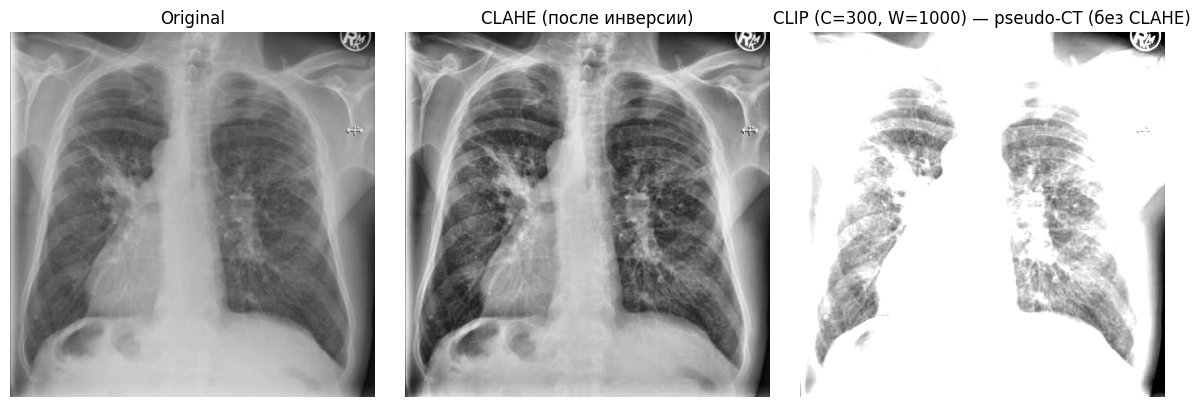

In [51]:
%%time
from PIL import Image
rg_path ="/kaggle/input/x-ray-lung-diseases-images-9-classes/05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)/05 (1).jpeg"
image = Image.open(rg_path)

arr, fig = preprocess_xray_pil_v4(image, preset="default", visualize=True)

# 2) переводим обратно в PIL.Image
import numpy as np
from PIL import Image

def arr_to_pil(arr):
    if arr.ndim == 2:           # [H,W], 0..1
        u8 = (np.clip(arr, 0, 1) * 255).astype(np.uint8)
        return Image.fromarray(u8, mode="L")
    elif arr.ndim == 3 and arr.shape[2] == 3:  # [H,W,3], 0..1
        u8 = (np.clip(arr, 0, 1) * 255).astype(np.uint8)
        return Image.fromarray(u8, mode="RGB")
    else:
        raise ValueError("Unexpected array shape")

processed_pil = arr_to_pil(arr)

w, h = processed_pil.size
print("Width:", w, "Height:", h)

#    input image size width: {w}, height {h}.
prompt = """
Task: classify chest CT scan into one of 9 diagnostic categories.

Possible classes:
1. Normal
2. Inflammatory processes (pneumonia)
3. Higher density (pleural effusion, atelectatic consolidation, hydrothorax, empyema)
4. Lower density (pneumotorax, pneumomediastinum, pneumoperitoneum)
5. Obstructive pulmonary diseases (emphysema, bronchopneumonia, bronchiectasis, embolism)
6. Degenerative infectious diseases (tuberculosis, sarcoidosis, proteinosis, fibrosis)
7. Encapsulated lesions (abscesses, nodules, cysts, tumor masses, metastases)
8. Mediastinal changes (pericarditis, arteriovenous malformations, lymph node enlargement)
9. Chest changes (atelectasis, malformations, agenesis, hypoplasia)

Steps:
1) Examine both lungs and mediastinum for relevant radiological signs.
2) Assign exactly one class from the list above that best matches the findings.
3) Output format:
   - class: [one of 1–9 categories above, verbatim]
   - probability in [0,1]
   - short justification (1–2 sentences)

Be concise.
"""


messages = [
    {"role": "system", "content": [{"type": "text", "text": "You are an expert radiologist."}]},
    {"role": "user", "content": [
        {"type": "text", "text": prompt},
        {"type": "image", "image": processed_pil},
    ]}
]

output = pipe(text=messages, max_new_tokens=256)
display(Markdown(output[0]["generated_text"][-1]["content"]))

In [88]:
# %%time
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import torch
from tqdm.auto import tqdm
from IPython.display import Markdown, display

# Dataset root and folders (as provided)
ROOT = Path("/kaggle/input/x-ray-lung-diseases-images-9-classes")
CLASS_DIRS = [
    "00 Anatomia Normal",
    "01 Processos Inflamatórios Pulmonares (Pneumonia)",
    "02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)",
    "03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)",
    "04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)",
    "05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)",
    "06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)",
    "07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)",
    "08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)",
]
N_PER_CLASS = 10

# Simple arr->PIL (same as your working snippet)
def arr_to_pil(arr):
    if arr.ndim == 2:           # [H,W], 0..1
        u8 = (np.clip(arr, 0, 1) * 255).astype(np.uint8)
        return Image.fromarray(u8, mode="L")
    elif arr.ndim == 3 and arr.shape[2] == 3:  # [H,W,3], 0..1
        u8 = (np.clip(arr, 0, 1) * 255).astype(np.uint8)
        return Image.fromarray(u8, mode="RGB")
    else:
        raise ValueError("Unexpected array shape")

rows = []

for class_name in CLASS_DIRS:
    class_path = ROOT / class_name
    if not class_path.exists():
        print(f"⚠️ Missing folder: {class_path}")
        continue
    if class_name == "00 Anatomia Normal":
        N_PER_CLASS = 80
    else:
        N_PER_CLASS = 10
    # first 50 images per folder
    image_paths = sorted([p for p in class_path.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png"}])[:N_PER_CLASS]
    if not image_paths:
        print(f"⚠️ No images in {class_name}")
        continue

    print(f"Processing '{class_name}' ({len(image_paths)} images)...")

    for img_path in tqdm(image_paths, leave=False):
        try:
            image = Image.open(img_path).convert("RGB")

            # Your preprocessing (matches your working example)
            arr = preprocess_xray_pil_v4(image, preset="default", visualize=False)

            processed_pil = arr_to_pil(arr)

            # Build your exact prompt/messages
            prompt = """
        Task: classify chest CT scan for pulmonary abnormalities.
        Steps:
        1) Examine both lungs for opacities, consolidations, ground-glass changes, pleural effusion, pneumothorax, fibrosis, or nodules.
        2) If no abnormalities are visible, output label: normal.
        3) If any abnormality is suspected, output label: anomaly and provide a short justification.
        4) Output format:
           - label: normal OR label: anomaly
           - probability in [0,1]
        Be concise.
        """

            messages = [
                {"role": "system", "content": [{"type": "text", "text": "You are an expert radiologist."}]},
                {"role": "user", "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "image": processed_pil},
                ]}
            ]

            # Call your model
            output = pipe(text=messages, max_new_tokens=256)

            # Extract text (kept minimal and inline)
            gen = output[0]["generated_text"][-1]["content"]
            if isinstance(gen, list):
                out_text = "\n".join([b.get("text", "") if isinstance(b, dict) else str(b) for b in gen])
            else:
                out_text = str(gen)

            # Inline parsing: label and probability
            m_label = re.search(r'\blabel\s*:\s*(normal|anomaly)\b', out_text, flags=re.IGNORECASE)
            pred_label = m_label.group(1).lower() if m_label else None

            m_prob = re.search(r'\bprobability\b[^0-9]*([01](?:\.\d+)?|\.\d+)', out_text, flags=re.IGNORECASE)
            pred_probability = float(np.clip(float(m_prob.group(1)), 0.0, 1.0)) if m_prob else None

            # Ground-truth 'label' column per your spec
            gt_label = None if class_name.startswith("00 ") else "anomaly"

            rows.append({
                "folder_name": class_name,
                "image_name": img_path.name,
                "label": gt_label,
                "pred_probability": pred_probability,
                "pred_label": pred_label
            })

        except Exception as e:
            rows.append({
                "folder_name": class_name,
                "image_name": img_path.name,
                "label": None if class_name.startswith("00 ") else "anomaly",
                "pred_probability": np.nan,
                "pred_label": f"ERROR: {e}"
            })

# Build and save DataFrame
df_results = pd.DataFrame(rows, columns=["folder_name", "image_name", "label", "pred_probability", "pred_label"])
print(f"✅ Done. Rows: {len(df_results)}")
display(df_results.head(10))

# out_csv = "/kaggle/working/xray_rg_preds.csv"
# df_results.to_csv(out_csv, index=False)
# print(f"📄 Saved to: {out_csv}")


Processing '00 Anatomia Normal' (80 images)...


  0%|          | 0/80 [00:00<?, ?it/s]

Processing '01 Processos Inflamatórios Pulmonares (Pneumonia)' (10 images)...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing '02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)' (10 images)...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing '03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)' (10 images)...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing '04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)' (10 images)...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing '05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)' (10 images)...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing '06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)' (10 images)...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing '07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)' (10 images)...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing '08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)' (10 images)...


  0%|          | 0/10 [00:00<?, ?it/s]

✅ Done. Rows: 160


folder_name      image_name label  pred_probability pred_label
0  00 Anatomia Normal     00 (1).jpeg  None               1.0     normal
1  00 Anatomia Normal      00 (1).jpg  None               1.0     normal
2  00 Anatomia Normal    00 (10).jpeg  None               1.0     normal
3  00 Anatomia Normal     00 (10).jpg  None               1.0     normal
4  00 Anatomia Normal   00 (100).jpeg  None               1.0     normal
5  00 Anatomia Normal  00 (1000).jpeg  None               1.0     normal
6  00 Anatomia Normal  00 (1001).jpeg  None               1.0     normal
7  00 Anatomia Normal  00 (1002).jpeg  None               1.0     normal
8  00 Anatomia Normal  00 (1003).jpeg  None               0.7    anomaly
9  00 Anatomia Normal  00 (1004).jpeg  None               1.0     normal

In [89]:
df_results[df_results.label.isna()].pred_label.value_counts()

pred_label
normal     78
anomaly     2
Name: count, dtype: int64

In [90]:
df_results[df_results.label.notna()].pred_label.value_counts()

pred_label
anomaly    65
normal     15
Name: count, dtype: int64

In [91]:
# anomaly probability
df_results["anom_prob"] = df_results["pred_probability"]
mask = df_results["pred_label"] == "normal"
df_results.loc[mask, "anom_prob"] = 1 - df_results.loc[mask, "pred_probability"]

# target: 0 if folder is "00 ..." (normal), else 1 (anomaly)
df_results["target"] = (~df_results["folder_name"].str.startswith("00 ")).astype(int)


# Quick check
df_results.head()


folder_name     image_name label  pred_probability pred_label  \
0  00 Anatomia Normal    00 (1).jpeg  None               1.0     normal   
1  00 Anatomia Normal     00 (1).jpg  None               1.0     normal   
2  00 Anatomia Normal   00 (10).jpeg  None               1.0     normal   
3  00 Anatomia Normal    00 (10).jpg  None               1.0     normal   
4  00 Anatomia Normal  00 (100).jpeg  None               1.0     normal   

   anom_prob  target  
0        0.0       0  
1        0.0       0  
2        0.0       0  
3        0.0       0  
4        0.0       0

In [92]:
df_results.groupby('target')['anom_prob'].agg('mean')

target
0    0.017500
1    0.739375
Name: anom_prob, dtype: float64

In [93]:
print(print(roc_auc_score(df_results.target, df_results.anom_prob)))
from sklearn.metrics import precision_recall_fscore_support

y_true = df_results["target"].values
y_score = df_results["anom_prob"].values

best_f1, best_thr, best_prec, best_rec = 0, None, None, None

for thr in np.linspace(0, 1, 101):  # перебор порогов от 0 до 1
    y_pred = (y_score >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr, best_prec, best_rec = f1, thr, prec, rec

print(f"Best threshold: {best_thr:.2f}")
print(f"Precision: {best_prec:.3f}, Recall: {best_rec:.3f}, F1: {best_f1:.3f}")


0.9034375
None
Best threshold: 0.01
Precision: 0.970, Recall: 0.812, F1: 0.884


# KT 3D

# LUNA16

In [7]:
luna_canidates = pd.read_csv('/kaggle/input/luna16/candidates.csv')
print(luna_canidates.shape)
print(luna_canidates['class'].value_counts()/luna_canidates.shape[0])


(551065, 5)


class
0    0.997548
1    0.002452
Name: count, dtype: float64

In [13]:
luna_grouped = luna_canidates.groupby(by='seriesuid').agg('max')
luna_grouped['class'].value_counts()/luna_grouped.shape[0]

class
1    0.664414
0    0.335586
Name: count, dtype: float64

In [17]:
!ls /kaggle/input/luna16

annotations.csv  evaluationScript      subset0	subset3
candidates.csv	 sampleSubmission.csv  subset1	subset4
candidates_V2	 seg-lungs-LUNA16      subset2


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found subset dirs: ['subset0', 'subset1', 'subset2', 'subset3', 'subset4']
Discovered .mhd volumes: 445
Available positives on disk with annotations: 306 -> using 20
Available negatives on disk: 139 -> using 40


Processing selected LUNA16 CTs: 100%|██████████| 60/60 [1:20:54<00:00, 80.91s/it] 


seriesuid  n_slices  n_used  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100530488926...       471      59   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100620385482...       126      32   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163...       171      43   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497...       280      47   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714...       219      37   

   count_normal  count_anomaly  prob_anomaly  y_true  y_pred  
0            58              1      0.016949       0       0  
1            29              3      0.093750       0       0  
2            43              0      0.000000       0       0  
3            28             19      0.404255       0       0  
4            32              5      0.135135       0       0

Total CTs evaluated: 60
ROC-AUC: 0.7100
Precision: 1.0000  Recall: 0.3000  F1: 0.4615


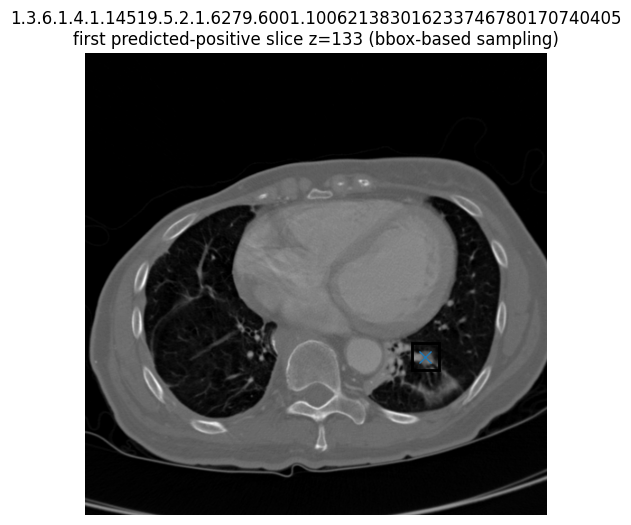

In [27]:
# === LUNA16 | Conditional sampling:
#     - label 0 (negatives): step-based sampling
#     - label 1 (positives): ONLY slices that intersect annotated bbox (from annotations.csv)
#   + evaluation (ROC-AUC, precision, recall, F1)
#   + visualize FIRST predicted-positive slice with bbox
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import SimpleITK as sitk
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# ----- EXACT SAME PROMPT (unchanged) -----
prompt = """
Task: classify chest CT scan for pulmonary abnormalities.
Steps:
1) Examine both lungs for opacities, consolidations, ground-glass changes, pleural effusion, pneumothorax, fibrosis, or nodules.
2) If no abnormalities are visible, output label: normal.
3) If any abnormality is suspected, output label: anomaly.
4) Output format:
   - label: normal OR label: anomaly
"""

# ----- helper functions -----
def select_step(n_slices: int) -> int:
    if n_slices < 50:   return 1
    elif n_slices < 100: return 2
    elif n_slices < 200: return 4
    elif n_slices < 400: return 6
    else:                return 8

def normalize_to_pil(slice_2d: np.ndarray) -> Image.Image:
    vmin, vmax = slice_2d.min(), slice_2d.max()
    if vmax <= vmin:
        u8 = np.zeros_like(slice_2d, dtype=np.uint8)
    else:
        u8 = (((slice_2d - vmin) / (vmax - vmin + 1e-6)) * 255.0).astype(np.uint8)
    return Image.fromarray(u8, mode="L")

def classify_images_with_preds(images, pipe, prompt):
    """Call your model exactly as before; return counts + per-slice 0/1 predictions."""
    counts = {"normal": 0, "anomaly": 0}
    preds = []
    for image in images:
        messages_test = [
            {"role": "system", "content": [{"type": "text", "text": "You are an expert radiologist."}]},
            {"role": "user",   "content": [{"type": "text", "text": prompt}, {"type": "image", "image": image}]}
        ]
        output = pipe(text=messages_test, max_new_tokens=256)
        text = output[0]["generated_text"][-1]["content"]
        label = None
        try:
            label = text.split(":")[1].split("\n")[0].strip().lower()
        except Exception:
            pass
        if label == "anomaly":
            counts["anomaly"] += 1
            preds.append(1)
        elif label == "normal":
            counts["normal"] += 1
            preds.append(0)
        else:
            # drop unparsable to keep alignment clean
            pass
    return counts, preds

# ----- dataset discovery -----
luna_root = "/kaggle/input/luna16"
candidates_csv  = os.path.join(luna_root, "candidates.csv")
annotations_csv = os.path.join(luna_root, "annotations.csv")

subset_dirs = [d for d in sorted(os.listdir(luna_root)) if d.startswith("subset") and os.path.isdir(os.path.join(luna_root, d))]
mhd_paths = glob.glob(os.path.join(luna_root, "subset*", "**", "*.mhd"), recursive=True)
available_series = {os.path.splitext(os.path.basename(p))[0]: p for p in mhd_paths}
print("Found subset dirs:", subset_dirs)
print(f"Discovered .mhd volumes: {len(available_series)}")

df_results = pd.DataFrame(columns=["seriesuid","n_slices","n_used","count_normal","count_anomaly","prob_anomaly","y_true","y_pred"])

if len(available_series) == 0:
    print("⚠️ No .mhd volumes found. Attach LUNA subsets with volumes.")
else:
    # 1) Determine CT-level labels using candidates.csv, and ensure POS CTs have annotations
    cand = pd.read_csv(candidates_csv)
    ct_has_pos = (cand.groupby("seriesuid")["class"].max() == 1)

    ann = pd.read_csv(annotations_csv)
    ann_series = set(ann["seriesuid"].unique())

    # Filter by on-disk series
    pos_all = [sid for sid in sorted(ct_has_pos[ct_has_pos].index.tolist()) if sid in available_series]
    neg_all = [sid for sid in sorted(ct_has_pos[~ct_has_pos].index.tolist()) if sid in available_series]

    # Additionally require annotations for positives (we need bbox-based sampling)
    pos_all_with_ann = [sid for sid in pos_all if sid in ann_series]

    # Pick up to 20/40
    pos_ids = pos_all_with_ann[:20]
    neg_ids = neg_all[:40]
    selected_ids = neg_ids + pos_ids

    print(f"Available positives on disk with annotations: {len(pos_all_with_ann)} -> using {len(pos_ids)}")
    print(f"Available negatives on disk: {len(neg_all)} -> using {len(neg_ids)}")

    if len(selected_ids) == 0:
        print("⚠️ No overlapping series for evaluation.")
    else:
        # Bind IO helpers to discovered paths
        def read_volume(seriesuid: str):
            p = available_series[seriesuid]
            img = sitk.ReadImage(p)
            arr_zyx = sitk.GetArrayFromImage(img)  # [Z,Y,X]
            spacing = np.array(img.GetSpacing())   # (sx,sy,sz)
            return img, arr_zyx, spacing

        # Pre-split annotations per series for quick access
        ann_by_series = {sid: df for sid, df in ann.groupby("seriesuid")}

        # 2) Conditional sampling:
        #    - label 0: z_indices = range(0, Z, step)
        #    - label 1: z_indices = union over nodules of z slices intersecting diameter along Z
        def positive_z_indices_from_bboxes(img, spacing, vol_zyx_shape, ann_df):
            """Get set of axial indices Z that intersect annotated nodules (bbox) for this CT."""
            Z = vol_zyx_shape[0]
            sz = float(spacing[2])  # spacing along Z (mm/vox)
            z_set = set()

            def world_to_index_xyz(world_xyz):
                idx_x, idx_y, idx_z = img.TransformPhysicalPointToIndex(tuple(world_xyz))
                return np.array([idx_x, idx_y, idx_z], dtype=float)

            for _, r in ann_df.iterrows():
                world_xyz = np.array([r["coordX"], r["coordY"], r["coordZ"]], dtype=float)
                diam_mm = float(r["diameter_mm"])
                idx_xyz = world_to_index_xyz(world_xyz)
                zc = float(idx_xyz[2])  # center in index-space
                # half-extent along Z in index units:
                hz = max(0.5, (diam_mm / sz) / 2.0)  # ensure at least some thickness
                z0 = int(np.floor(zc - hz))
                z1 = int(np.ceil (zc + hz))
                z0 = max(0, min(Z-1, z0))
                z1 = max(0, min(Z-1, z1))
                for z in range(z0, z1+1):
                    z_set.add(z)
            if not z_set:
                return []
            return sorted(z_set)

        # 3) Run model
        results = []
        per_ct_detail = {}
        y_true_ct = {sid: (1 if sid in pos_ids else 0) for sid in selected_ids}

        for sid in tqdm(selected_ids, desc="Processing selected LUNA16 CTs"):
            img, vol_zyx, spacing = read_volume(sid)
            Z, H, W = vol_zyx.shape

            if y_true_ct[sid] == 1:
                # positive: bbox-driven slice selection
                ann_ct = ann_by_series.get(sid, None)
                if ann_ct is None or ann_ct.empty:
                    # If (unexpectedly) no annotations, skip this CT (we must not use default sampling for label=1)
                    # Alternatively, you can fall back to default step sampling; here we skip to match your instruction strictly.
                    # print(f"Skipping {sid}: positive but has no annotations.")
                    continue
                z_indices = positive_z_indices_from_bboxes(img, spacing, vol_zyx.shape, ann_ct)
                if len(z_indices) == 0:
                    # No intersecting slices (very unlikely) -> skip
                    # print(f"Skipping {sid}: no z-slices intersecting bboxes.")
                    continue
            else:
                # negative: default step-based sampling
                step = select_step(Z)
                z_indices = list(range(0, Z, step))

            # Build PIL images
            pil_slices = [normalize_to_pil(vol_zyx[z]) for z in z_indices]

            counts, preds = classify_images_with_preds(pil_slices, pipe, prompt)
            total_used = counts["normal"] + counts["anomaly"]
            prob_anom = (counts["anomaly"] / total_used) if total_used > 0 else 0.0
            y_true = y_true_ct[sid]
            y_pred = 1 if counts["anomaly"] > counts["normal"] else 0  # majority vote

            results.append({
                "seriesuid": sid,
                "n_slices": Z,
                "n_used": len(z_indices),
                "count_normal": counts["normal"],
                "count_anomaly": counts["anomaly"],
                "prob_anomaly": prob_anom,
                "y_true": y_true,
                "y_pred": y_pred,
            })
            per_ct_detail[sid] = {
                "img": img,
                "vol_zyx": vol_zyx,
                "spacing": spacing,
                "z_indices": z_indices,
                "preds": preds,        # one entry per successfully parsed slice (same order as z_indices)
            }

        df_results = pd.DataFrame(results)
        display(df_results.head())
        print(f"Total CTs evaluated: {len(df_results)}")

        # 4) Metrics
        if len(df_results) == 0:
            print("⚠️ No CTs evaluated; skipping metrics.")
        else:
            y_true = df_results["y_true"].values
            y_score = df_results["prob_anomaly"].values
            try:
                roc_auc = roc_auc_score(y_true, y_score)
            except ValueError:
                roc_auc = float("nan")
            y_pred = df_results["y_pred"].values
            prec = precision_score(y_true, y_pred, zero_division=0)
            rec  = recall_score(y_true, y_pred, zero_division=0)
            f1   = f1_score(y_true, y_pred, zero_division=0)
            print(f"ROC-AUC: {roc_auc:.4f}")
            print(f"Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")

        # 5) Visualization: FIRST slice predicted as "anomaly" with bbox on that exact slice
        def try_plot_first_positive_slice_with_bbox():
            if len(df_results) == 0:
                print("No CTs available for visualization.")
                return False

            # Iterate positives only; our positive sampling ensures z_indices are bbox-intersecting
            for sid in [s for s in selected_ids if y_true_ct[s] == 1 and s in per_ct_detail]:
                det = per_ct_detail[sid]
                preds = det["preds"]
                z_indices = det["z_indices"]
                if len(preds) != len(z_indices) or len(z_indices) == 0:
                    continue

                first_idx = next((i for i, p in enumerate(preds) if p == 1), None)
                if first_idx is None:
                    continue

                z = z_indices[first_idx]
                vol_zyx = det["vol_zyx"]
                spacing = det["spacing"]
                img     = det["img"]

                # Choose an annotation that actually covers this z index
                ann_ct = ann_by_series.get(sid, None)
                if ann_ct is None or ann_ct.empty:
                    continue

                def world_to_index_xyz(world_xyz):
                    idx_x, idx_y, idx_z = img.TransformPhysicalPointToIndex(tuple(world_xyz))
                    return np.array([idx_x, idx_y, idx_z], dtype=float)

                # Filter annotations whose Z-span intersects z
                sz = float(spacing[2])
                ann_ct = ann_ct.copy()
                idx_coords = ann_ct.apply(lambda r: world_to_index_xyz([r["coordX"], r["coordY"], r["coordZ"]]), axis=1, result_type="expand")
                ann_ct[["idx_x","idx_y","idx_z"]] = idx_coords
                ann_ct["hz"] = ann_ct["diameter_mm"] / sz / 2.0
                ann_ct["z0"] = np.floor(ann_ct["idx_z"] - ann_ct["hz"]).astype(int)
                ann_ct["z1"] = np.ceil (ann_ct["idx_z"] + ann_ct["hz"]).astype(int)
                ann_ct["covers_z"] = (ann_ct["z0"] <= z) & (z <= ann_ct["z1"])
                ann_cover = ann_ct[ann_ct["covers_z"]]
                if ann_cover.empty:
                    # if no single bbox strictly covers z (rare rounding case), pick the closest one
                    ann_ct["abs_dz"] = (ann_ct["idx_z"] - z).abs()
                    ann_cover = ann_ct.sort_values(["abs_dz","diameter_mm"], ascending=[True, False]).head(1)

                nod = ann_cover.iloc[0]
                x_idx = int(np.clip(round(nod["idx_x"]), 0, vol_zyx.shape[2]-1))
                y_idx = int(np.clip(round(nod["idx_y"]), 0, vol_zyx.shape[1]-1))
                diameter_mm = float(nod["diameter_mm"])

                # Draw on slice z
                slice_2d = vol_zyx[z]
                vis = normalize_to_pil(slice_2d)

                sx, sy, sz = spacing
                hx = max(3, int(round((diameter_mm / sx) / 2.0)))
                hy = max(3, int(round((diameter_mm / sy) / 2.0)))
                x1, x2 = int(np.clip(x_idx - hx, 0, slice_2d.shape[1]-1)), int(np.clip(x_idx + hx, 0, slice_2d.shape[1]-1))
                y1, y2 = int(np.clip(y_idx - hy, 0, slice_2d.shape[0]-1)), int(np.clip(y_idx + hy, 0, slice_2d.shape[0]-1))

                plt.figure(figsize=(6,6))
                plt.imshow(vis, cmap="gray")
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2)
                plt.gca().add_patch(rect)
                plt.plot([x_idx], [y_idx], marker="x", markersize=8)
                plt.title(f"{sid}\nfirst predicted-positive slice z={z} (bbox-based sampling)")
                plt.axis("off")
                plt.show()
                return True

            print("No slice predicted as 'anomaly' with available bbox among the evaluated positive CTs.")
            return False

        _ = try_plot_first_positive_slice_with_bbox()


In [28]:
df_results.groupby('y_true')['prob_anomaly'].agg('mean')

y_true
0    0.090909
1    0.330931
Name: prob_anomaly, dtype: float64

In [32]:
df_results

seriesuid  n_slices  n_used  \
0   1.3.6.1.4.1.14519.5.2.1.6279.6001.100530488926...       471      59   
1   1.3.6.1.4.1.14519.5.2.1.6279.6001.100620385482...       126      32   
2   1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163...       171      43   
3   1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497...       280      47   
4   1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714...       219      37   
5   1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131...       273      46   
6   1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...       121      31   
7   1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339...       196      49   
8   1.3.6.1.4.1.14519.5.2.1.6279.6001.113586291551...       413      52   
9   1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991...       111      28   
10  1.3.6.1.4.1.14519.5.2.1.6279.6001.116492508532...       139      35   
11  1.3.6.1.4.1.14519.5.2.1.6279.6001.117383608379...       133      34   
12  1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896...       124      31   
13  1.3.6.1.4.1.14519.5.2.1.6279.6001.125067060506...       130      33   
14  1.3.6.1.4.1.14519.5.2.1.6279.6001.125356649712...       241      41   
15  1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017...       133      34   
16  1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843...       295      50   
17  1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690...       456      57   
18  1.3.6.1.4.1.14519.5.2.1.6279.6001.139595277234...       172      43   
19  1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241...       140      35   
20  1.3.6.1.4.1.14519.5.2.1.6279.6001.140527383975...       125      32   
21  1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068...       157      40   
22  1.3.6.1.4.1.14519.5.2.1.6279.6001.144943344795...       225      38   
23  1.3.6.1.4.1.14519.5.2.1.6279.6001.145283812746...       144      36   
24  1.3.6.1.4.1.14519.5.2.1.6279.6001.145474881373...       123      31   
25  1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666...       730      92   
26  1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507...       132      33   
27  1.3.6.1.4.1.14519.5.2.1.6279.6001.152684536713...       179      45   
28  1.3.6.1.4.1.14519.5.2.1.6279.6001.156322145453...       484      61   
29  1.3.6.1.4.1.14519.5.2.1.6279.6001.156579001330...       449      57   
30  1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677...       138      35   
31  1.3.6.1.4.1.14519.5.2.1.6279.6001.159521777966...       127      32   
32  1.3.6.1.4.1.14519.5.2.1.6279.6001.160216916075...       201      34   
33  1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822...       133      34   
34  1.3.6.1.4.1.14519.5.2.1.6279.6001.161073793312...       133      34   
35  1.3.6.1.4.1.14519.5.2.1.6279.6001.162207236104...       477      60   
36  1.3.6.1.4.1.14519.5.2.1.6279.6001.163931625580...       477      60   
37  1.3.6.1.4.1.14519.5.2.1.6279.6001.171919524048...       122      31   
38  1.3.6.1.4.1.14519.5.2.1.6279.6001.172845185165...       217      37   
39  1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420...       127      32   
40  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...       321      70   
41  1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...       133       7   
42  1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...       280      13   
43  1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...       133       5   
44  1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...       328      15   
45  1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...       259      38   
46  1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...       119       5   
47  1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525...       238       7   
48  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...       161      18   
49  1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...       538       9   
50  1.3.6.1.4.1.14519.5.2.1.6279.6001.114195693932...       255       7   
51  1.3.6.1.4.1.14519.5.2.1.6279.6001.114218724025...       509      41   
52  1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382...       548      

In [31]:
print(print(roc_auc_score(df_results.y_true, df_results.prob_anomaly)))
from sklearn.metrics import precision_recall_fscore_support

y_true = df_results["y_true"].values
y_score = df_results["prob_anomaly"].values

best_f1, best_thr, best_prec, best_rec = 0, None, None, None

for thr in np.linspace(0, 1, 101):  # перебор порогов от 0 до 1
    y_pred = (y_score >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr, best_prec, best_rec = f1, thr, prec, rec

print(f"Best threshold: {best_thr:.2f}")
print(f"Precision: {best_prec:.3f}, Recall: {best_rec:.3f}, F1: {best_f1:.3f}")


0.71
None
Best threshold: 0.16
Precision: 0.700, Recall: 0.700, F1: 0.700
